Maybe buena cosa sería usar GYM en un custom Environment:
- https://towardsdatascience.com/getting-started-with-openai-gym-d2ac911f5cbc
- https://www.gymlibrary.dev/content/environment_creation/
- https://www.gymlibrary.dev/content/vectorising/
- https://blog.paperspace.com/getting-started-with-openai-gym/

El verdadero CHAD: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/9da0471a9eeb2351a488cd4b44fc6bbf/reinforcement_q_learning.ipynb#scrollTo=m_WKkK0sH3Tp


- TEstear arquitecturas de RNN

In [2]:
# Permitir acceso a Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import os
from functools import reduce

# Buscar la ruta donde está el proyecto, cambiar en caso de ser necesario
project_path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/RL-Cacho-main')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
project_path

'/content/drive/MyDrive/Colab Notebooks/RL-Cacho-main'

In [5]:
import math
import random
from collections import namedtuple, deque
from itertools import count, product
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Buscar la ruta donde está el proyecto, cambiar en caso de ser necesario
os.chdir('/content/drive/My Drive/Colab Notebooks/RL-Cacho-main/')
print("Directorio actual:", os.getcwd())

Directorio actual: /content/drive/My Drive/Colab Notebooks/RL-Cacho-main


In [7]:
from src.models.EnvironmentCachos import NPC, Strategic_NPC, AmbienteCacho
from src.models.Agents import AgentTable, Agent, Agent_SARSA, Agent_QLearning
from src.models.utils import train_over_games, play_one_game, plot_winrate, winrate_every, plot_time_per_game, Q_plot, plot_epsilon

## Demostración del Juego con el "Agente Racional"

In [8]:
game_env = AmbienteCacho(2)
placeholder = Strategic_NPC()
play_one_game(game_env, placeholder, verbose = True, graphs = False, NPC=True)

En esta ronda, los jugadores tenían los dados:
[array([0, 3, 0, 1, 1, 0], dtype=int32), array([0, 1, 1, 1, 0, 2], dtype=int32)]
El Agente jugó (1, 'Tontos')
Oponente 1 Played:  (1, 'Sextas')
El Agente jugó (2, 'Sextas')
Oponente 1 Played:  (3, 'Sextas')
El Agente jugó Dudo
1 ('Agent Dudó Bien', -1) (array([0, 3, 0, 1, 1, 0], dtype=int32), [5, 4], (3, 'Sextas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([1, 1, 0, 2, 1, 0], dtype=int32), array([1, 0, 2, 0, 0, 1], dtype=int32)]
El Oponente partió jugando (1, 'Trenes')
El Agente jugó (1, 'Cuadras')
Oponente 1 Played:  (2, 'Cuadras')
El Agente jugó (3, 'Cuadras')
Oponente 1 Played:  Dudo
1 ('Oponente 1 Dudo Mal', 1) (array([1, 1, 0, 2, 1, 0], dtype=int32), [5, 3], (3, 'Cuadras'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([0, 0, 1, 2, 0, 2], dtype=int32), arr

(-1, None, 0.056847649)

# Evolución del WinRate a lo largo del aprendizaje

In [9]:
# Bajar n_games si tarda mucho en ejecutar
n_games = 100
every = n_games//100
gamma = 0.99
epsilon0 = 1
epsdecay = 0.01
epsmin = 0.001
lr = 0.1
scores_dict = {"x": every* np.arange(n_games//every)}
times_dict = {"x": np.arange(n_games)}
epsilon_dict = {"x": np.arange(n_games)}
game_env = AmbienteCacho(2, NPC_type = Strategic_NPC)

## Agente Tabular Entrenado con Monte Carlo Control

In [10]:
agente_MC = AgentTable(gamma = gamma, epsilon = epsilon0, lr = lr, game_env = game_env, eps_end = epsmin, eps_dec = epsdecay, eps_method = "Lineal", name = "Agente MC")
scores, eps_hist, times = train_over_games(game_env, agente_MC, n_games, mode = "Tabular", verbose = False)
print(np.mean(scores))
scores_dict["MC Control"] = winrate_every(scores, every)
times_dict["MC Control"] = times
epsilon_dict["MC Control"] = eps_hist
agente_MC.save_table(project_path+"/models/QTable_AgentMC_1M")

----------------------------------------
Creando el Juego 1
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.95
Tiempo por iteración (promedio últimos 100 episodios): 0.0015 s
----------------------------------------
Creando el Juego 2
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.85
Tiempo por iteración (promedio últimos 100 episodios): 0.002 s
----------------------------------------
Creando el Juego 3
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.78
Tiempo por iteración (promedio últimos 100 episodios): 0.002 s
----------------------------------------
Creando el Juego 4
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.69
Tiempo por iteración (promedio últimos 100 episodios): 0.002 s
----------------------------------------
Creando el Juego 5
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.6
Tiempo por iteración (promedio últimos 100 episo

## Agente Tabular Entrenado con SARSA

In [11]:
agente_SARSA = Agent_SARSA(gamma = gamma, epsilon = epsilon0, lr = lr, game_env = game_env, eps_end = epsmin, eps_dec = epsdecay, eps_method = "Lineal", name = "Agente SARSA")
scores, eps_hist, times = train_over_games(game_env, agente_SARSA, n_games, mode = "1-step", verbose = False)
print(np.mean(scores))
scores_dict["SARSA"] = winrate_every(scores, every)
times_dict["SARSA"] = times
epsilon_dict["SARSA"] = eps_hist

agente_SARSA.save_table(project_path+"/models/QTable_AgentSARSA1M")

----------------------------------------
Creando el Juego 1
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.95
Tiempo por iteración (promedio últimos 100 episodios): 0.0013 s
----------------------------------------
Creando el Juego 2
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.88
Tiempo por iteración (promedio últimos 100 episodios): 0.0015 s
----------------------------------------
Creando el Juego 3
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.81
Tiempo por iteración (promedio últimos 100 episodios): 0.0016 s
----------------------------------------
Creando el Juego 4
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.73
Tiempo por iteración (promedio últimos 100 episodios): 0.0017 s
----------------------------------------
Creando el Juego 5
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.66
Tiempo por iteración (promedio últimos 100 e

## Agente Tabular Entrenado con QLearning

In [12]:
agente_QLearning = Agent_QLearning(gamma = gamma, epsilon = epsilon0, lr = lr, game_env = game_env, eps_end = epsmin, eps_dec = epsdecay, eps_method = "Lineal", name =  "Agente QLearning")
scores, eps_hist, times = train_over_games(game_env, agente_QLearning, n_games, mode = "1-step", verbose = False)
print(np.mean(scores))
scores_dict["QLearning"] = winrate_every(scores, every)
times_dict["QLearning"] = times
epsilon_dict["QLearning"] = eps_hist

agente_QLearning.save_table(project_path+"/models/QTable_AgentQLearning1M")

----------------------------------------
Creando el Juego 1
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.94
Tiempo por iteración (promedio últimos 100 episodios): 0.0015 s
----------------------------------------
Creando el Juego 2
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.86
Tiempo por iteración (promedio últimos 100 episodios): 0.0019 s
----------------------------------------
Creando el Juego 3
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.8
Tiempo por iteración (promedio últimos 100 episodios): 0.0018 s
----------------------------------------
Creando el Juego 4
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.73
Tiempo por iteración (promedio últimos 100 episodios): 0.0018 s
----------------------------------------
Creando el Juego 5
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.65
Tiempo por iteración (promedio últimos 100 ep

In [13]:
df_wr = pd.DataFrame(scores_dict)
df_times = pd.DataFrame(times_dict)
df_epsilons = pd.DataFrame(epsilon_dict)

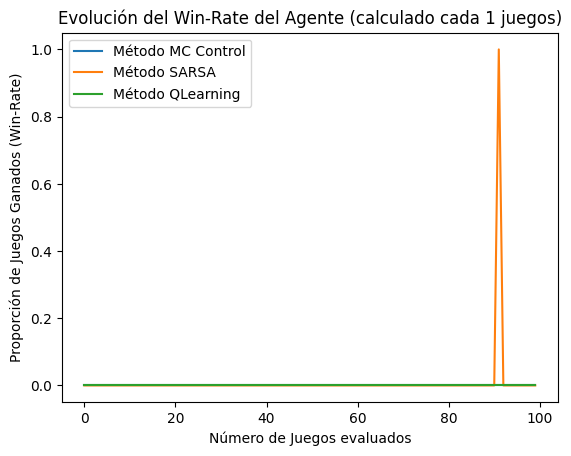

In [14]:
plot_winrate(df_wr, every)

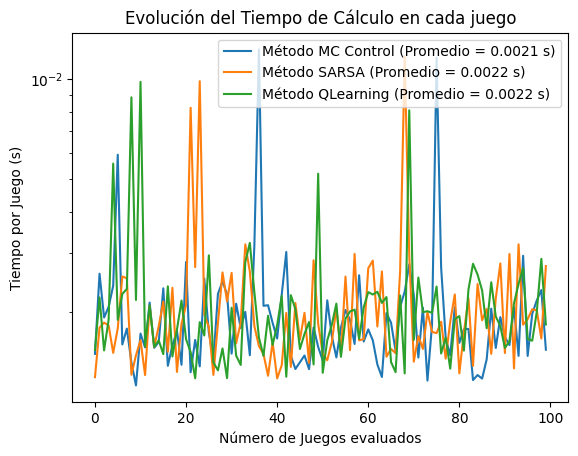

x             49.500000
MC Control     0.002072
SARSA          0.002160
QLearning      0.002183
dtype: float64


In [15]:
plot_time_per_game(df_times, m = every)
print(df_times.mean())

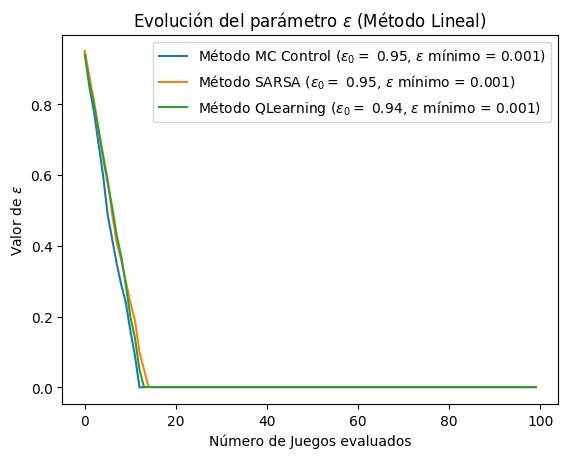

In [16]:
plot_epsilon(df_epsilons, m = every, metodo = "Lineal")

# Guardando las Q_Tables asociadas a los agentes en archivos

# Visualización de las Q_Tables

## Cargando Modelos Preentrenados

In [17]:
agente_MC.load_table(project_path+"/models/QTable_AgentMC")
agente_SARSA.load_table(project_path+"/models/QTable_AgentSARSA")
agente_QLearning.load_table(project_path+"/models/QTable_AgentQLearning")

## Visualizando las tablas de reward por acción en un estado fijo

In [18]:
estado = ((0,0,0,1,1,1),(3,3), (2, "Trenes"))

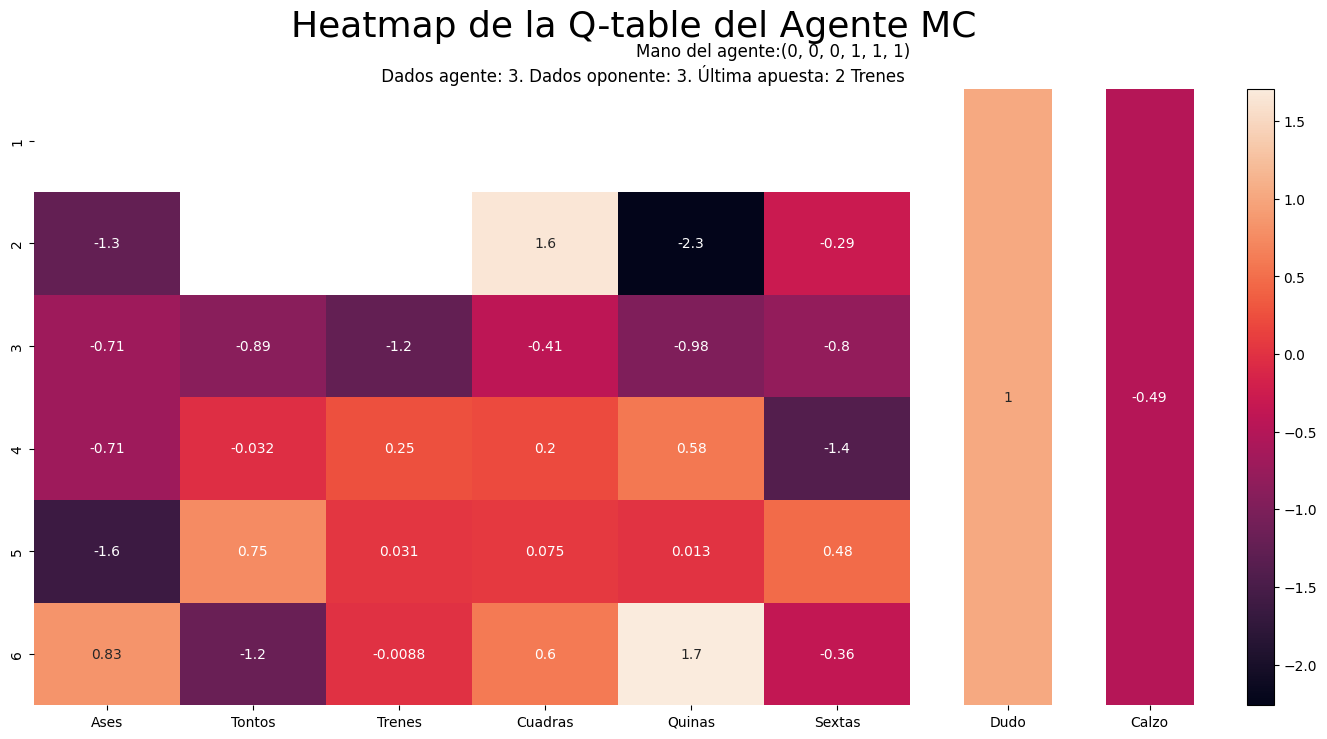

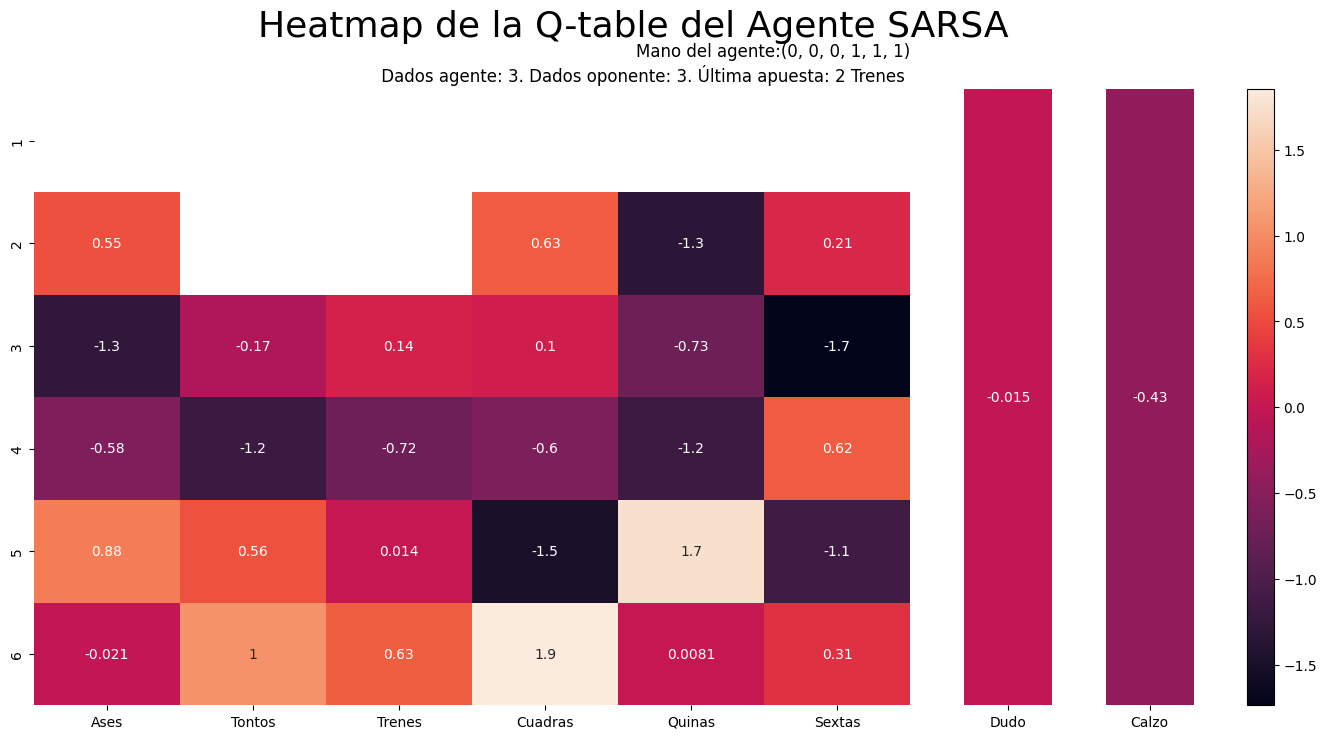

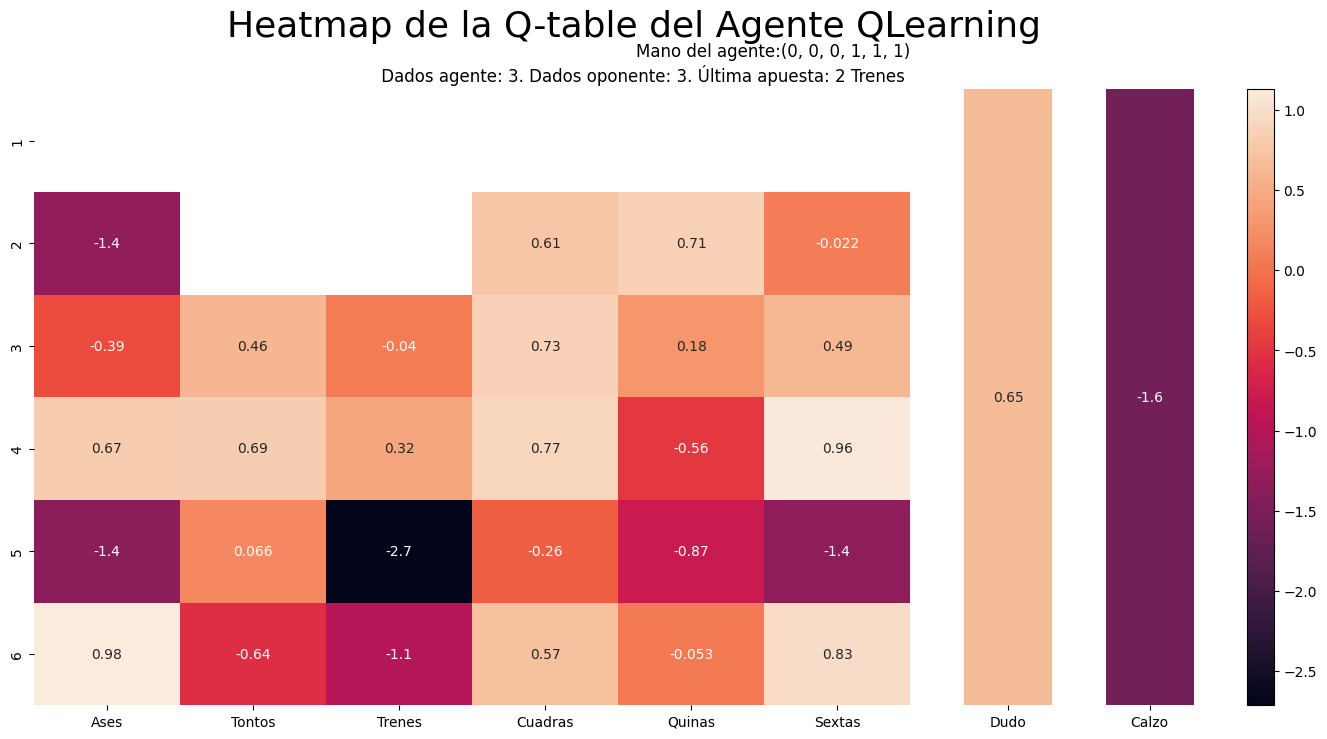

In [17]:
Q_plot(agente_MC, estado)
Q_plot(agente_SARSA, estado)
Q_plot(agente_QLearning, estado)

## Visión del agente al Jugar un Juego:

En esta ronda, los jugadores tenían los dados:
[array([1, 0, 0, 1, 3, 0], dtype=int32), array([1, 2, 2, 0, 0, 0], dtype=int32)]


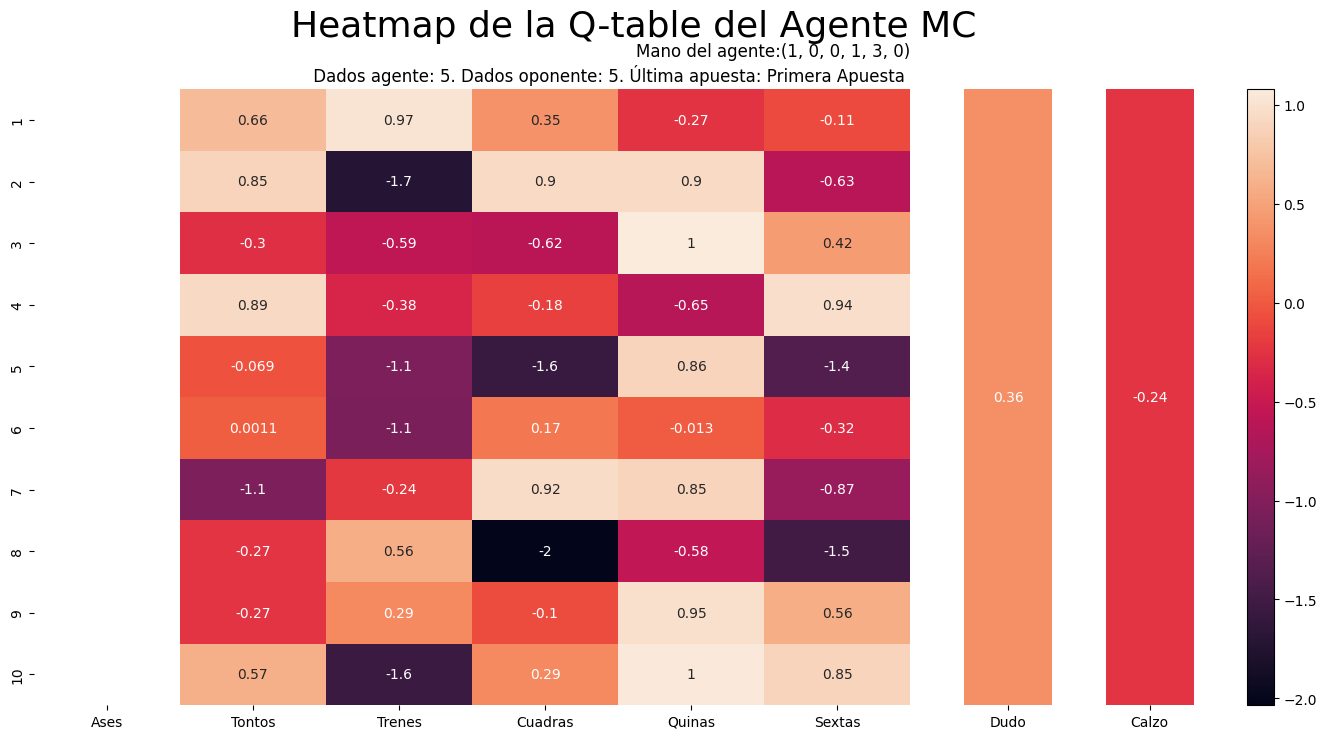

El Agente jugó (3, 'Quinas')
Oponente 1 Played:  Dudo
1 ('Oponente 1 Dudo Mal', 1) (array([1, 0, 0, 1, 3, 0], dtype=int32), [5, 4], (3, 'Quinas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([1, 1, 1, 1, 0, 1], dtype=int32), array([0, 1, 1, 0, 2, 0], dtype=int32)]
El Oponente partió jugando (1, 'Quinas')


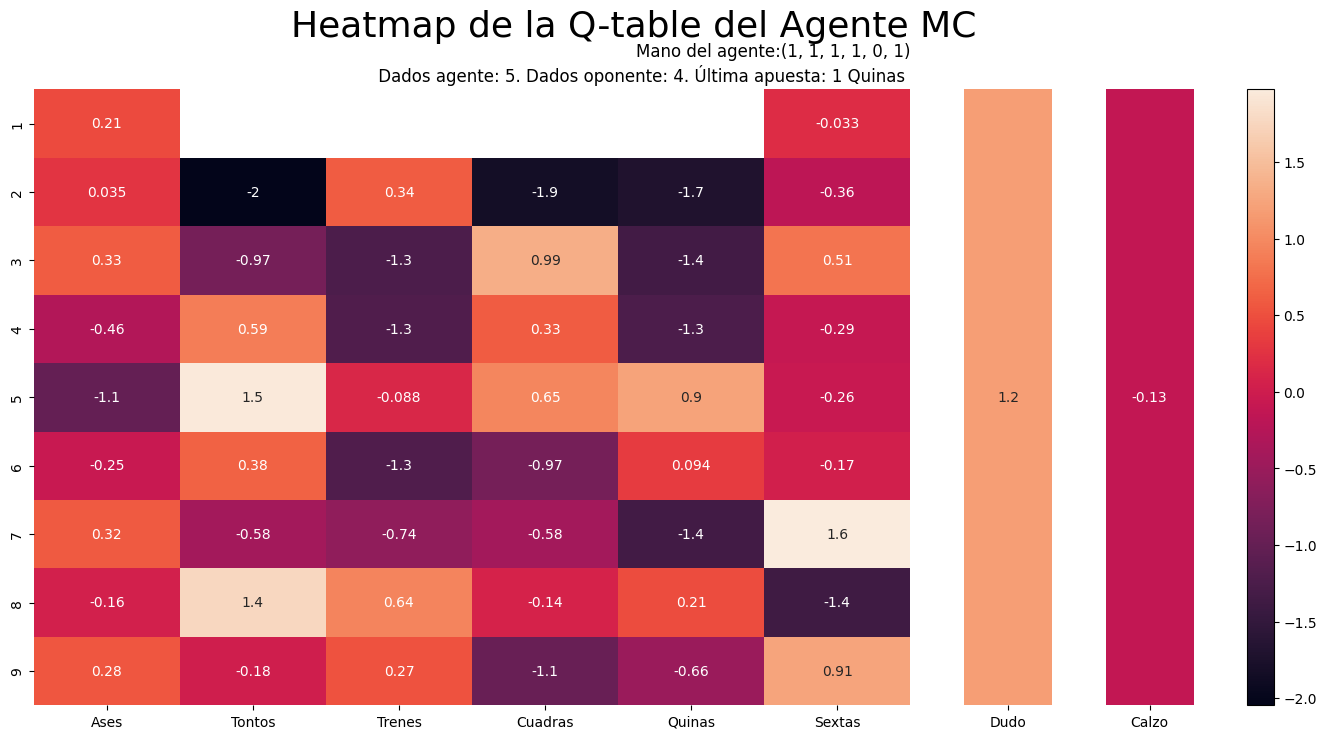

El Agente jugó (7, 'Sextas')
Oponente 1 Played:  Dudo
-1 ('Oponente 1 Dudó bien', 0) (array([1, 1, 1, 1, 0, 1], dtype=int32), [4, 4], (7, 'Sextas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([1, 1, 0, 0, 1, 1], dtype=int32), array([1, 0, 0, 1, 1, 1], dtype=int32)]


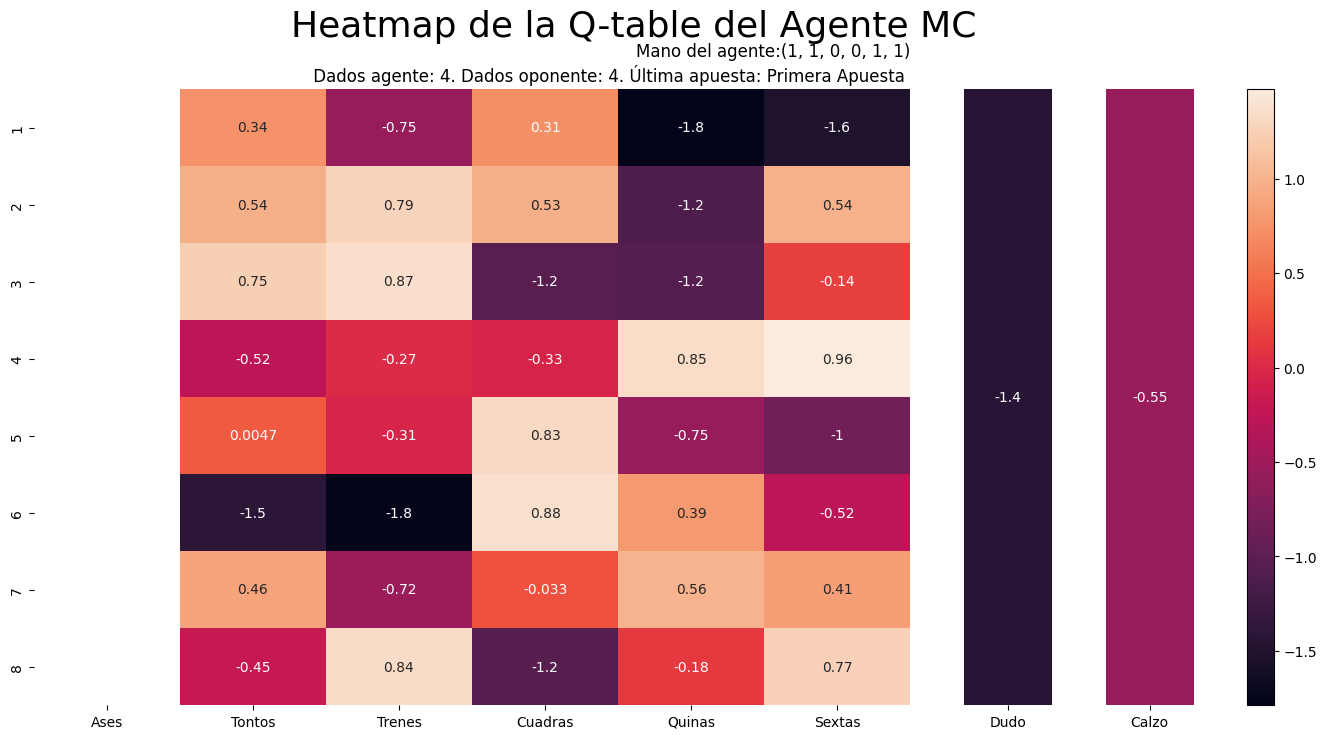

El Agente jugó (4, 'Sextas')
Oponente 1 Played:  Dudo
1 ('Oponente 1 Dudo Mal', 1) (array([1, 1, 0, 0, 1, 1], dtype=int32), [4, 3], (4, 'Sextas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([1, 0, 1, 1, 0, 1], dtype=int32), array([0, 0, 0, 1, 1, 1], dtype=int32)]
El Oponente partió jugando (1, 'Cuadras')


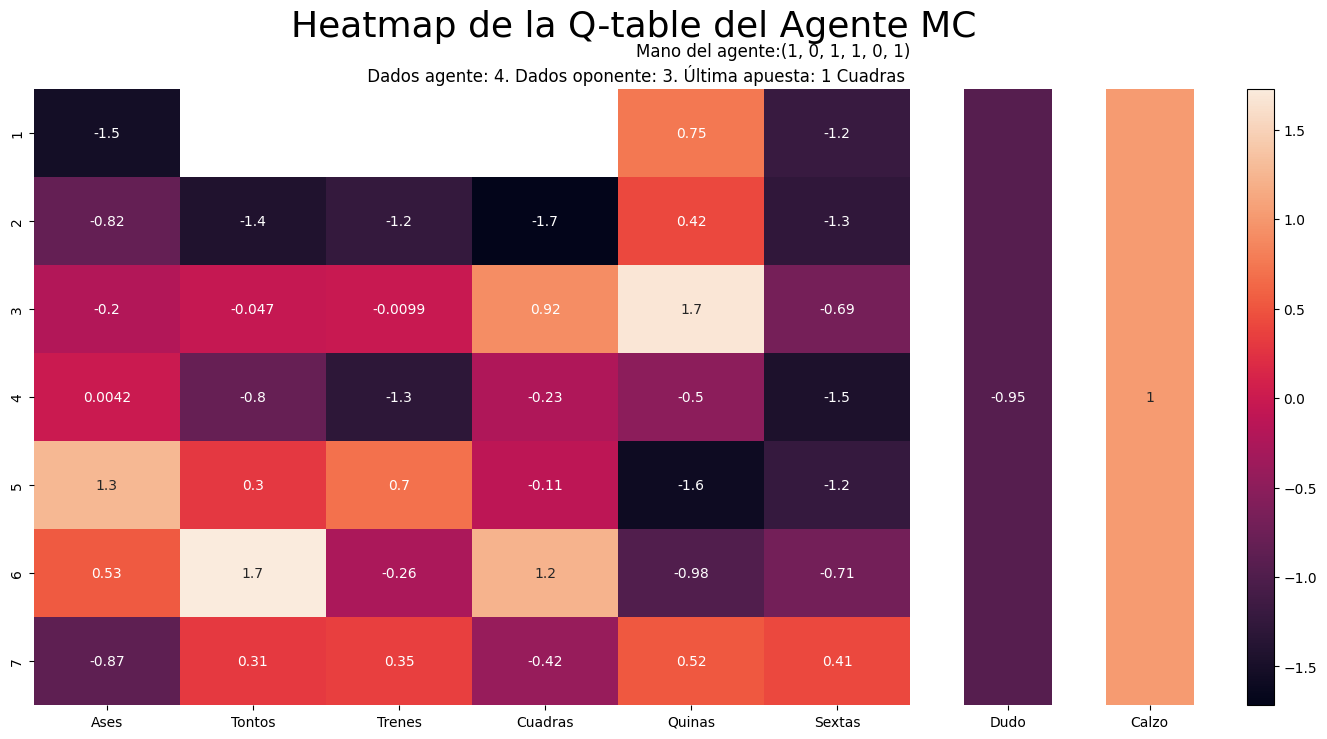

El Agente jugó (6, 'Tontos')
Oponente 1 Played:  Dudo
-1 ('Oponente 1 Dudó bien', 0) (array([1, 0, 1, 1, 0, 1], dtype=int32), [3, 3], (6, 'Tontos'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([2, 0, 0, 0, 0, 1], dtype=int32), array([1, 0, 1, 1, 0, 0], dtype=int32)]


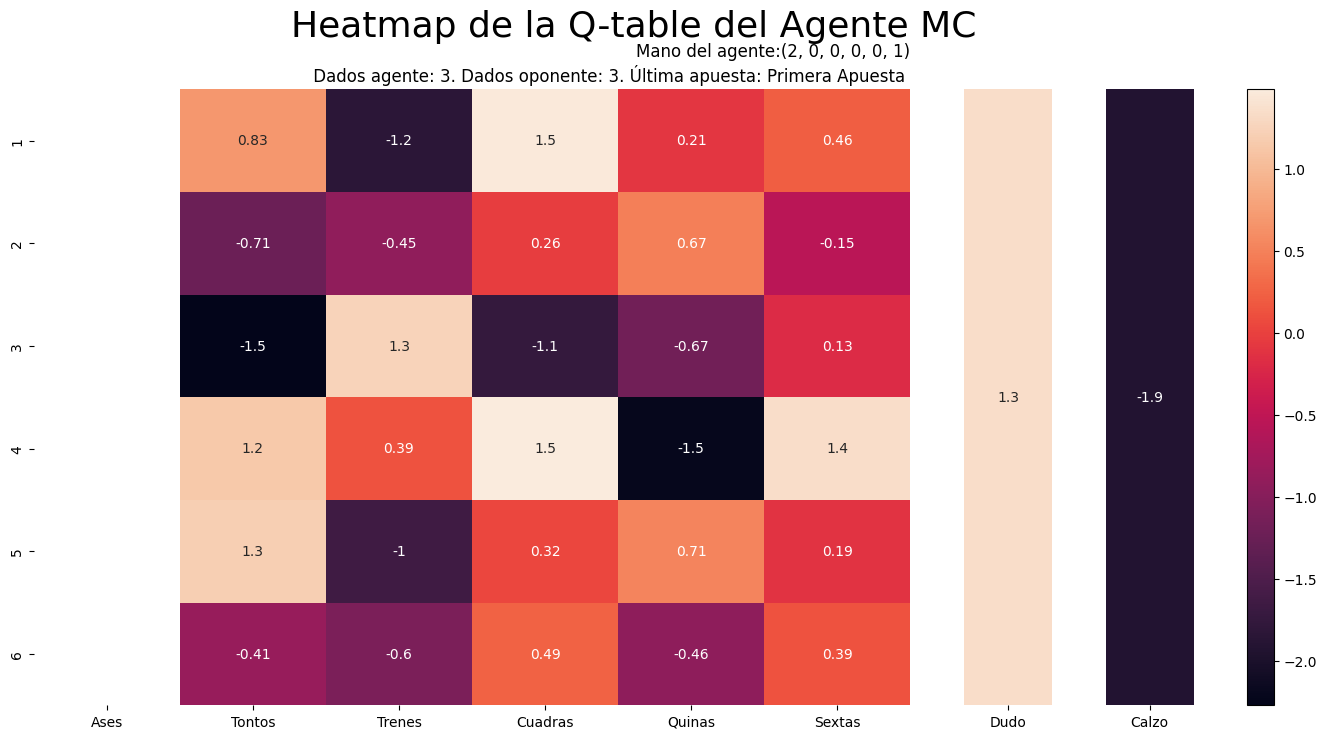

El Agente jugó (4, 'Cuadras')
Oponente 1 Played:  Dudo
1 ('Oponente 1 Dudo Mal', 1) (array([2, 0, 0, 0, 0, 1], dtype=int32), [3, 2], (4, 'Cuadras'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([0, 1, 0, 0, 1, 1], dtype=int32), array([0, 2, 0, 0, 0, 0], dtype=int32)]
El Oponente partió jugando (1, 'Tontos')


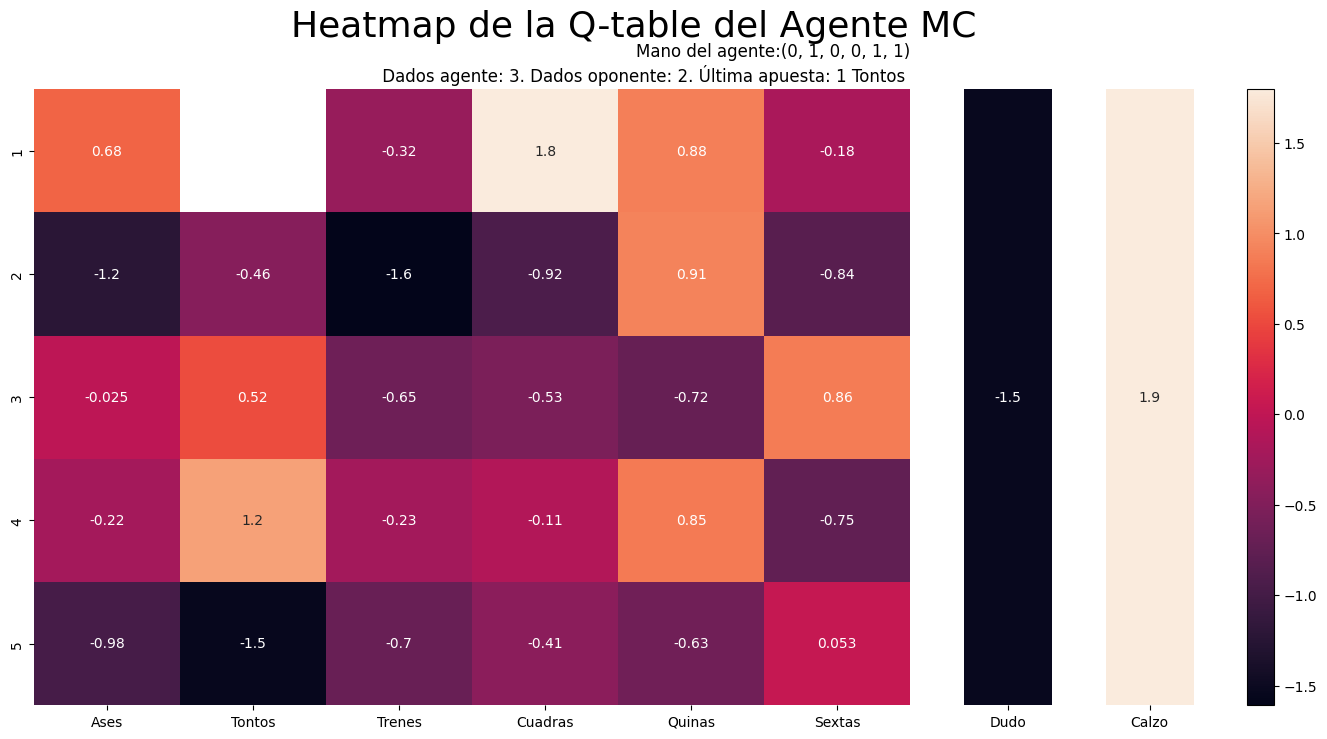

El Agente jugó Calzo
-1 ('Agent Calzo Mal', 0) (array([0, 1, 0, 0, 1, 1], dtype=int32), [2, 2], None)
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([1, 0, 1, 0, 0, 0], dtype=int32), array([0, 1, 0, 1, 0, 0], dtype=int32)]


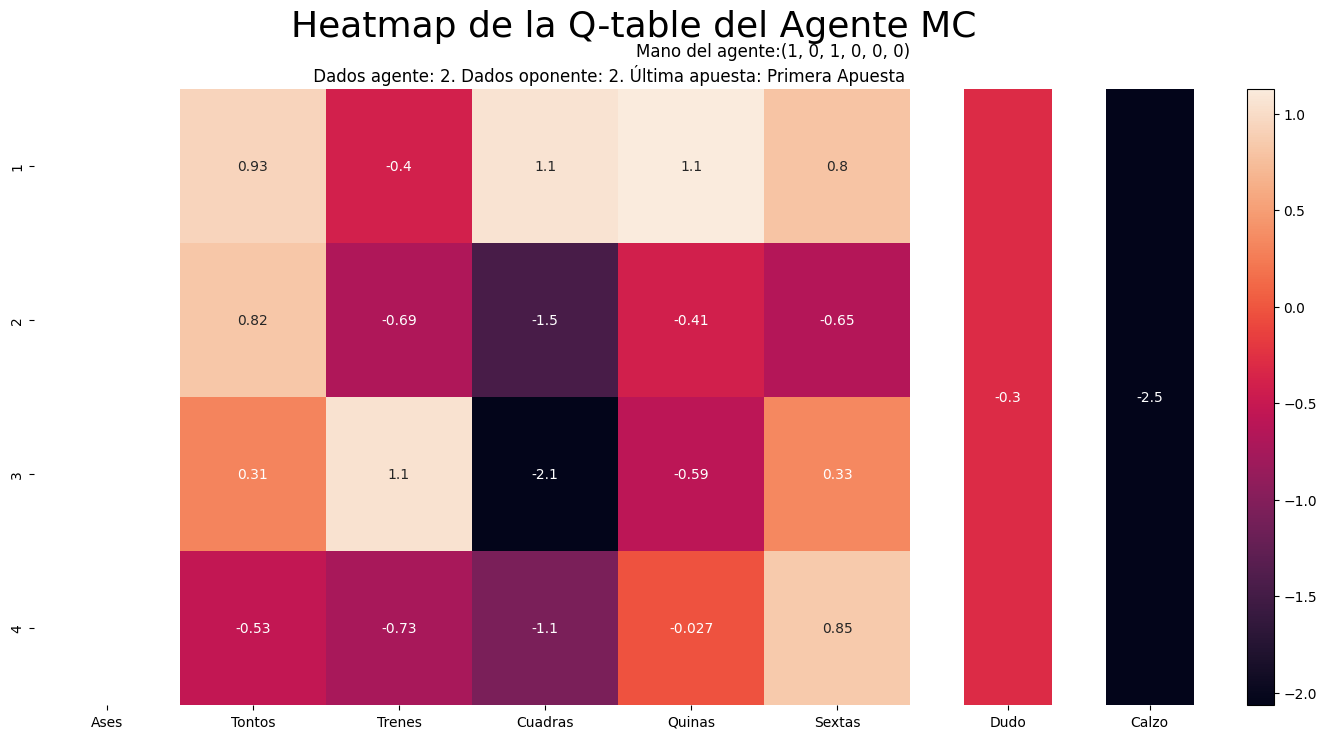

El Agente jugó (1, 'Quinas')
Oponente 1 Played:  Dudo
1 ('Oponente 1 Dudo Mal', 1) (array([1, 0, 1, 0, 0, 0], dtype=int32), [2, 1], (1, 'Quinas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([0, 0, 0, 0, 2, 0], dtype=int32), array([0, 1, 0, 0, 0, 0], dtype=int32)]
El Oponente partió jugando (1, 'Tontos')


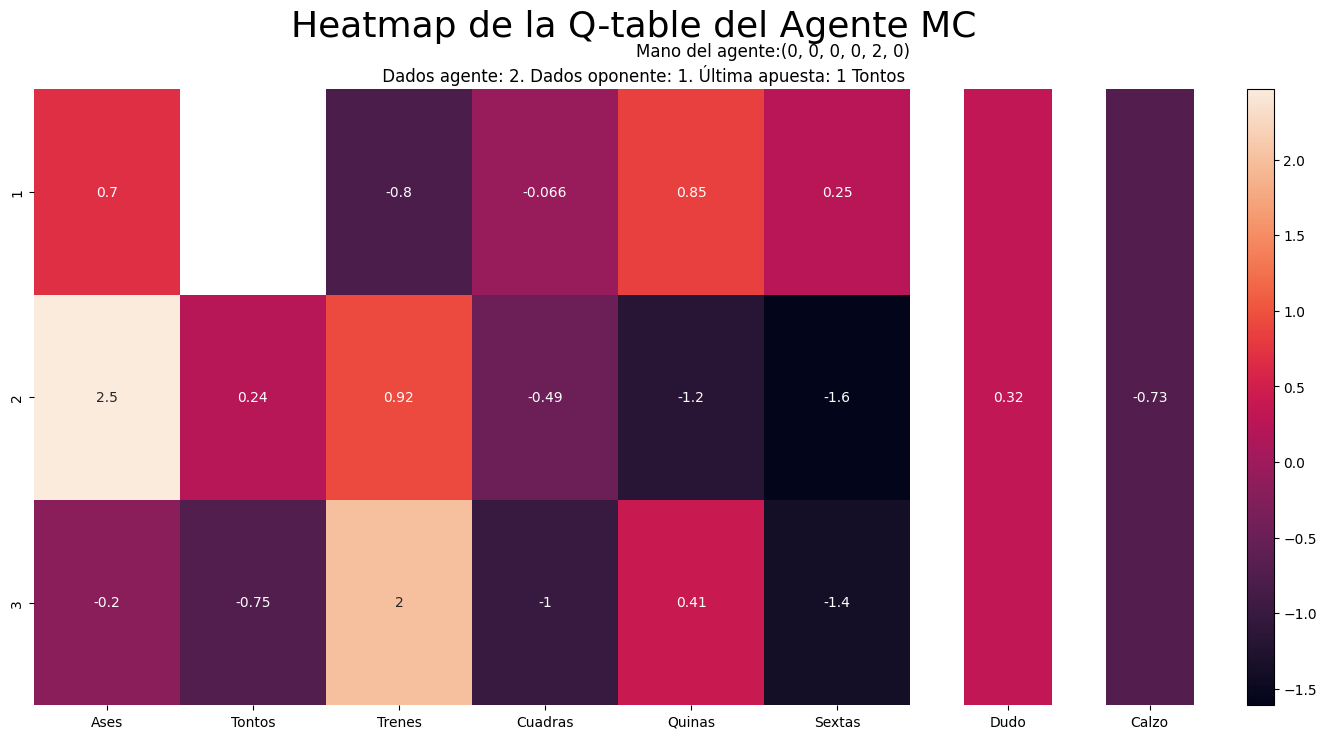

El Agente jugó (2, 'Ases')


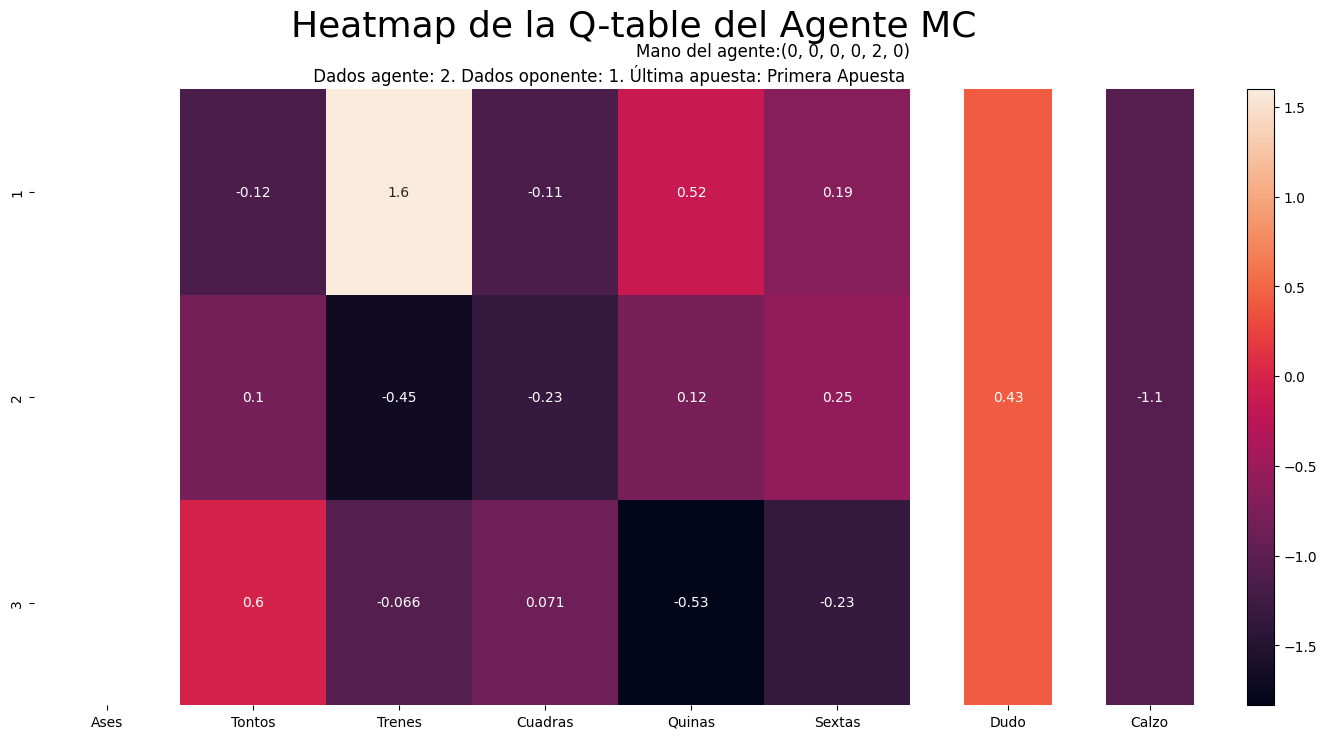

El Agente jugó (1, 'Trenes')
Oponente 1 Played:  Dudo
-2 ('Oponente 1 Dudó bien', 0) (array([0, 0, 0, 0, 2, 0], dtype=int32), [1, 1], (1, 'Trenes'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([0, 0, 0, 0, 1, 0], dtype=int32), array([0, 0, 0, 0, 1, 0], dtype=int32)]


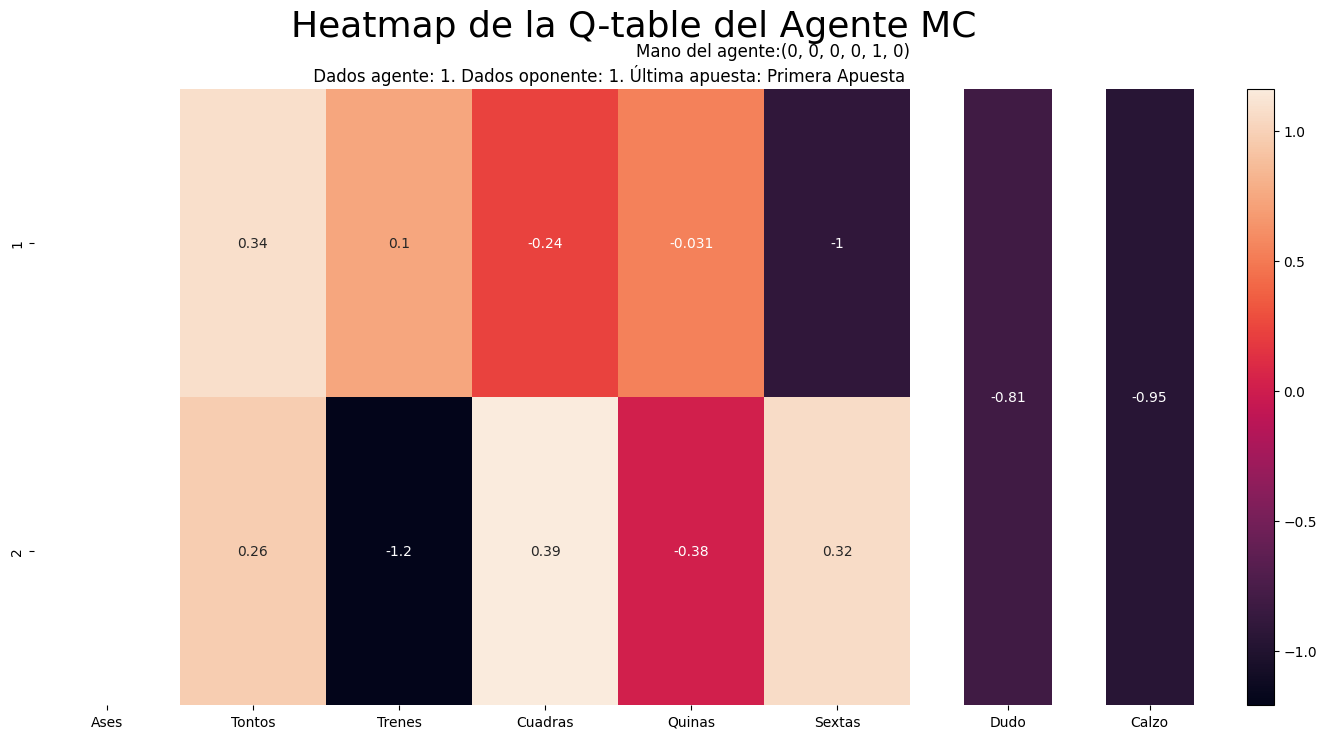

El Agente jugó (2, 'Cuadras')
Oponente 1 Played:  Dudo
OPPONENT WINS !
-1 ('Oponente 1 Dudó bien', 0) (array([0, 0, 0, 0, 1, 0], dtype=int32), [0, 1], (2, 'Cuadras'))
--------------------------------------------------------------------------------
Fin del Juego


(-1, 0.001, 7.7687721210000005)

In [19]:
play_one_game(game_env, agente_MC, verbose = True, graphs = True, tabular = True)

# Uso de Deep QLearning

In [20]:
# Bajar n_games si tarda mucho en ejecutar
n_games = 1000
every = n_games//100
gamma = 0.99
epsilon0 = 1.
epsdecay = 1e-3
lr = 0.001
scores_dict = {"x": every* np.arange(n_games//every)}
times_dict = {"x": np.arange(n_games)}
epsilon_dict = {"x": np.arange(n_games)}
game_env = AmbienteCacho(2, NPC_type = Strategic_NPC)

In [21]:
agente_DQN = Agent(gamma=gamma, epsilon=epsilon0, batch_size=64, game_env= game_env, eps_dec=epsdecay, eps_end=0.001, input_dims=[10], lr=lr)

In [22]:
scores, eps_hist, times = train_over_games(game_env, agente_DQN, n_games, mode = "Deep", Target_Update = 50000, verbose = False)
print(np.mean(scores))
scores_dict["Deep QLearning"] = winrate_every(scores, every)
times_dict["Deep QLearning"] = times
epsilon_dict["Deep QLearning"] = eps_hist

----------------------------------------
Creando el Juego 1
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 1.0
Tiempo por iteración (promedio últimos 100 episodios): 0.0084 s
----------------------------------------
Creando el Juego 11
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.988
Tiempo por iteración (promedio últimos 100 episodios): 0.1271 s
----------------------------------------
Creando el Juego 21
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.918
Tiempo por iteración (promedio últimos 100 episodios): 0.0817 s
----------------------------------------
Creando el Juego 31
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.837
Tiempo por iteración (promedio últimos 100 episodios): 0.0637 s
----------------------------------------
Creando el Juego 41
Resultados Parciales:
Winrate (últimos 100 episodios): 0.0
Epsilon actual: 0.765
Tiempo por iteración (promedio último

In [23]:
df_wr = pd.DataFrame(scores_dict)
df_times = pd.DataFrame(times_dict)
df_epsilons = pd.DataFrame(epsilon_dict)

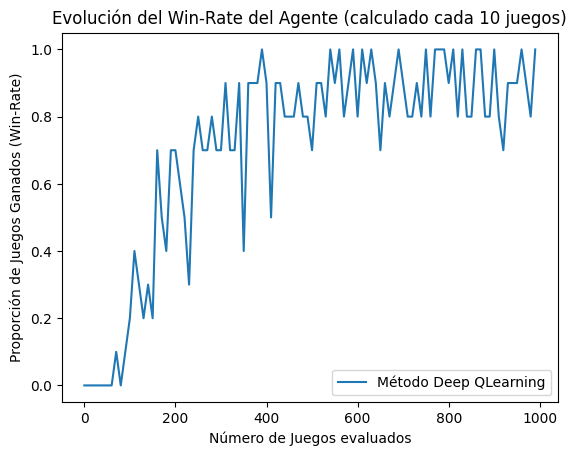

In [24]:
plot_winrate(df_wr, every)

In [25]:
df_times.mean()

x                 499.5000
Deep QLearning      0.0528
dtype: float64

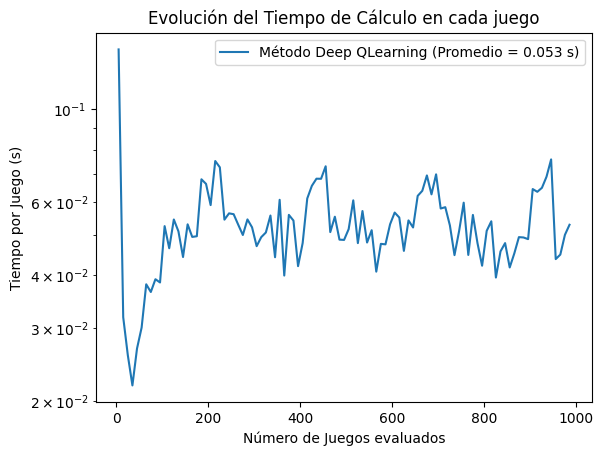

x                 499.5000
Deep QLearning      0.0528
dtype: float64


In [26]:
plot_time_per_game(df_times, m = every)
print(df_times.mean())

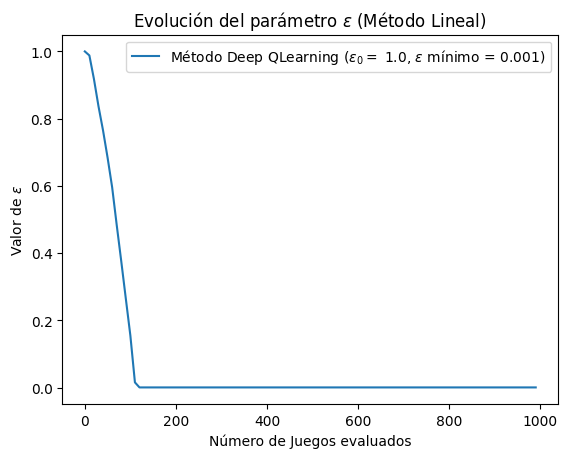

In [27]:
plot_epsilon(df_epsilons, m = every, metodo = "Lineal")

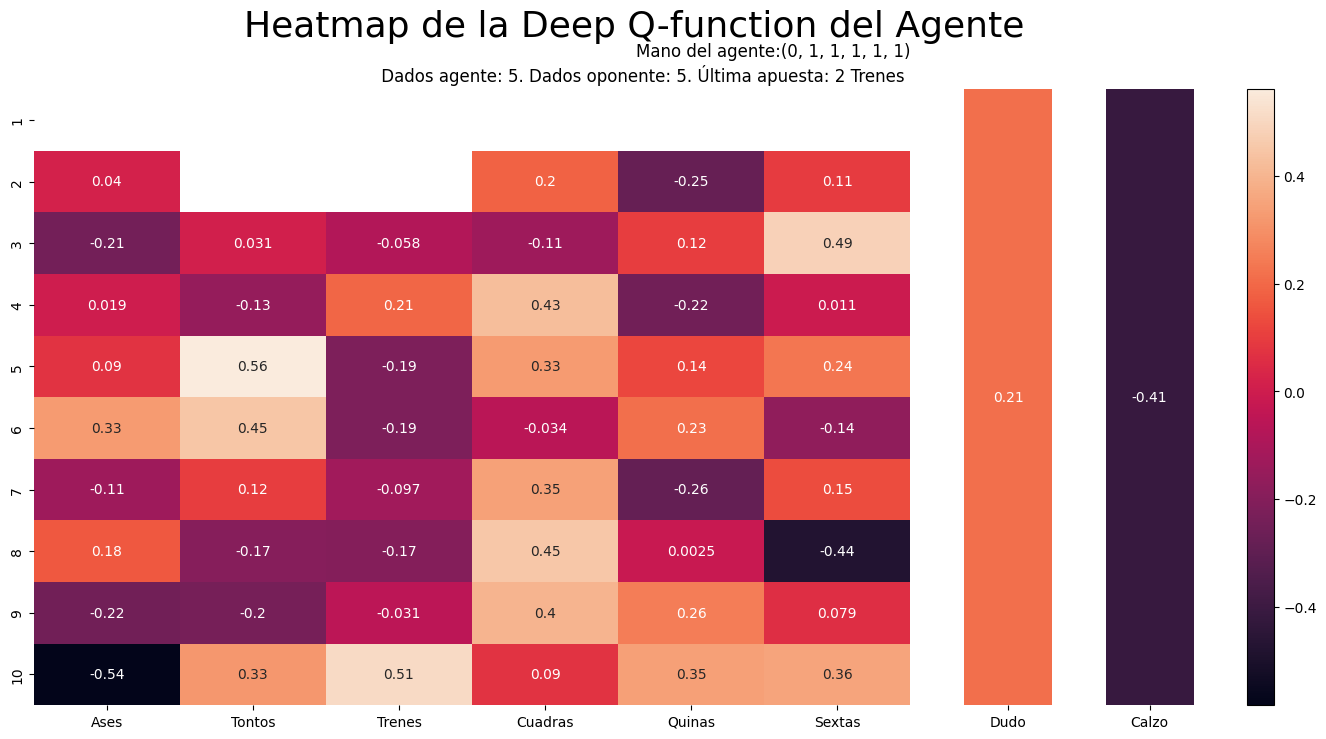

In [28]:
Q_plot(agente_DQN, ((0,1,1,1,1,1),(5,5), (2, "Trenes")), tabular = False)

In [29]:
# Buscar la ruta donde está el proyecto, cambiar en caso de ser necesario
agente_DQN.save("/content/drive/MyDrive/Colab Notebooks/RL-Cacho-main/models/QNetwork_{}eps_{}dec.pt".format(n_games, epsdecay))

In [30]:
# Buscar la ruta donde está el proyecto, cambiar en caso de ser necesario
agente_DQN2 = Agent(gamma=gamma, epsilon=0.01, batch_size=64, game_env=game_env, eps_end=0.01, input_dims=[10], lr=lr)
agente_DQN2.load("/content/drive/MyDrive/Colab Notebooks/RL-Cacho-main/models/QNetwork_{}eps_{}dec.pt".format(n_games, epsdecay))

En esta ronda, los jugadores tenían los dados:
[array([0, 0, 1, 0, 3, 1], dtype=int32), array([2, 2, 0, 0, 0, 1], dtype=int32)]


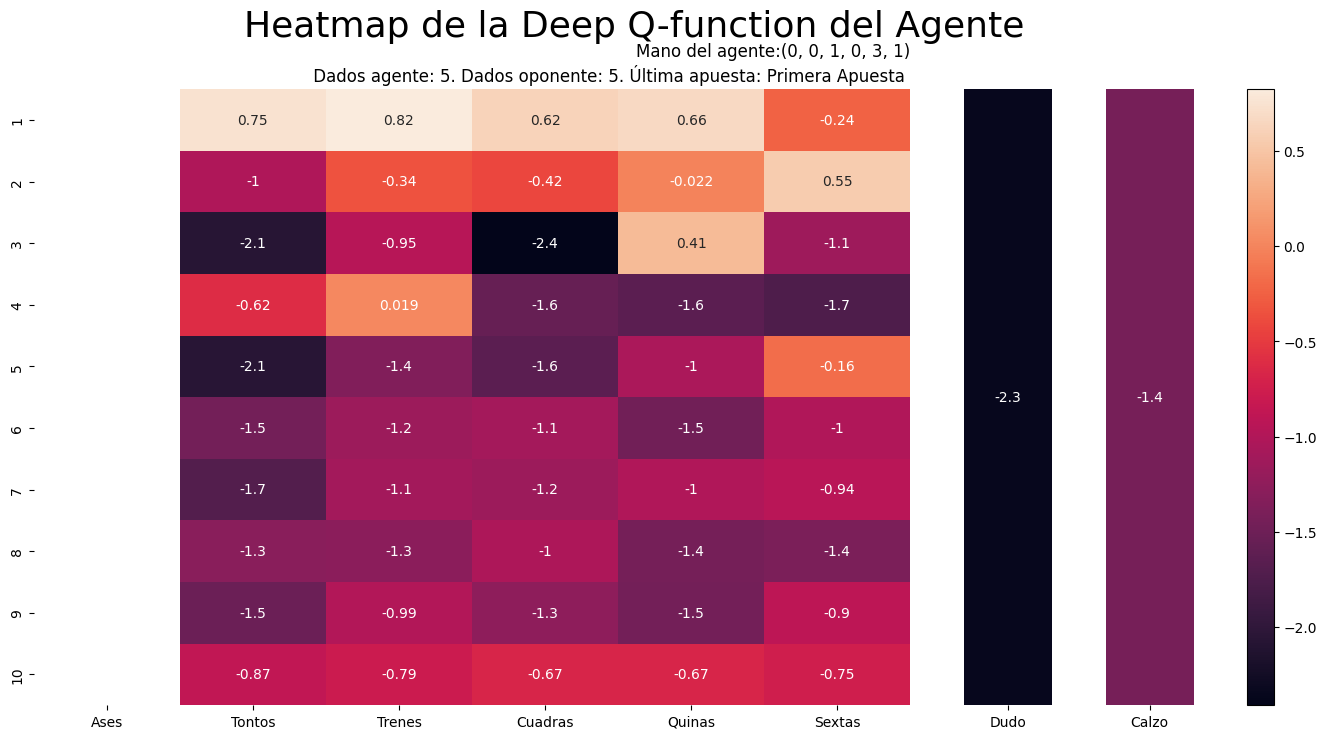

El Agente jugó (1, 'Trenes')
Oponente 1 Played:  (2, 'Trenes')


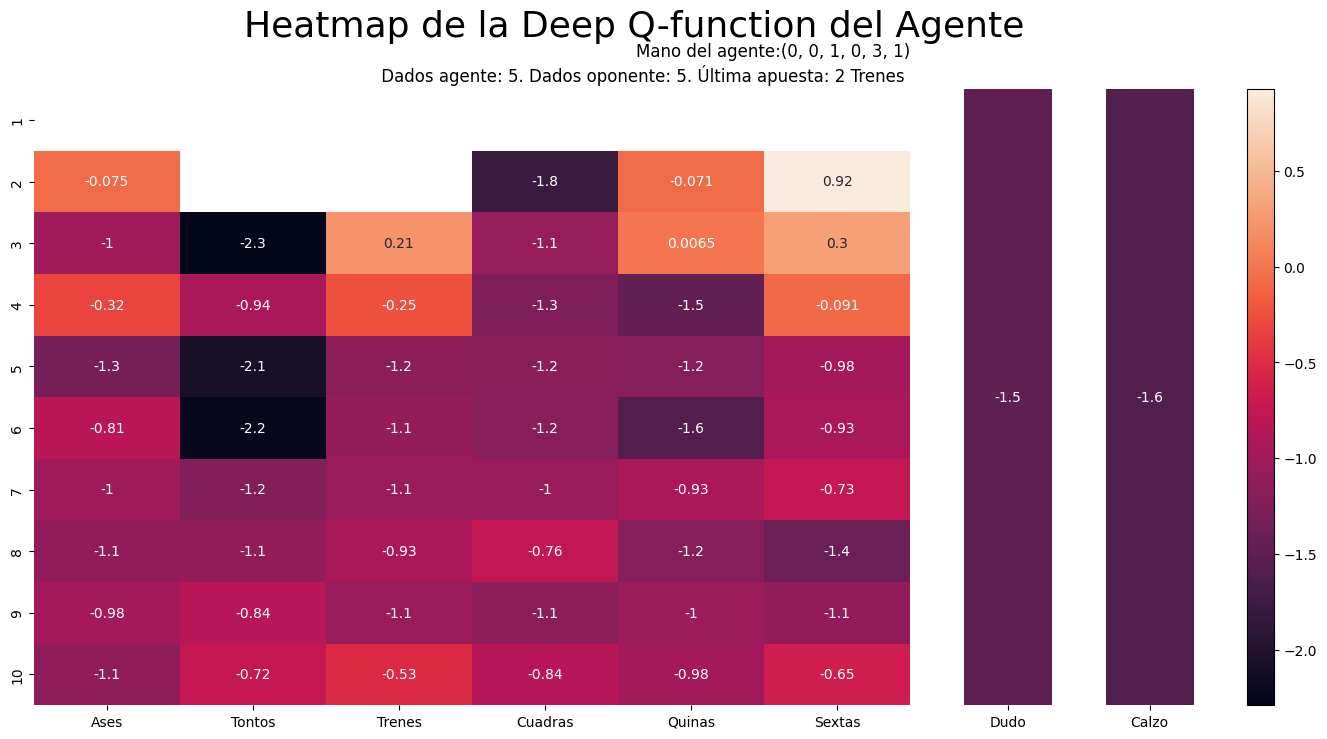

El Agente jugó (2, 'Sextas')
Oponente 1 Played:  (3, 'Sextas')


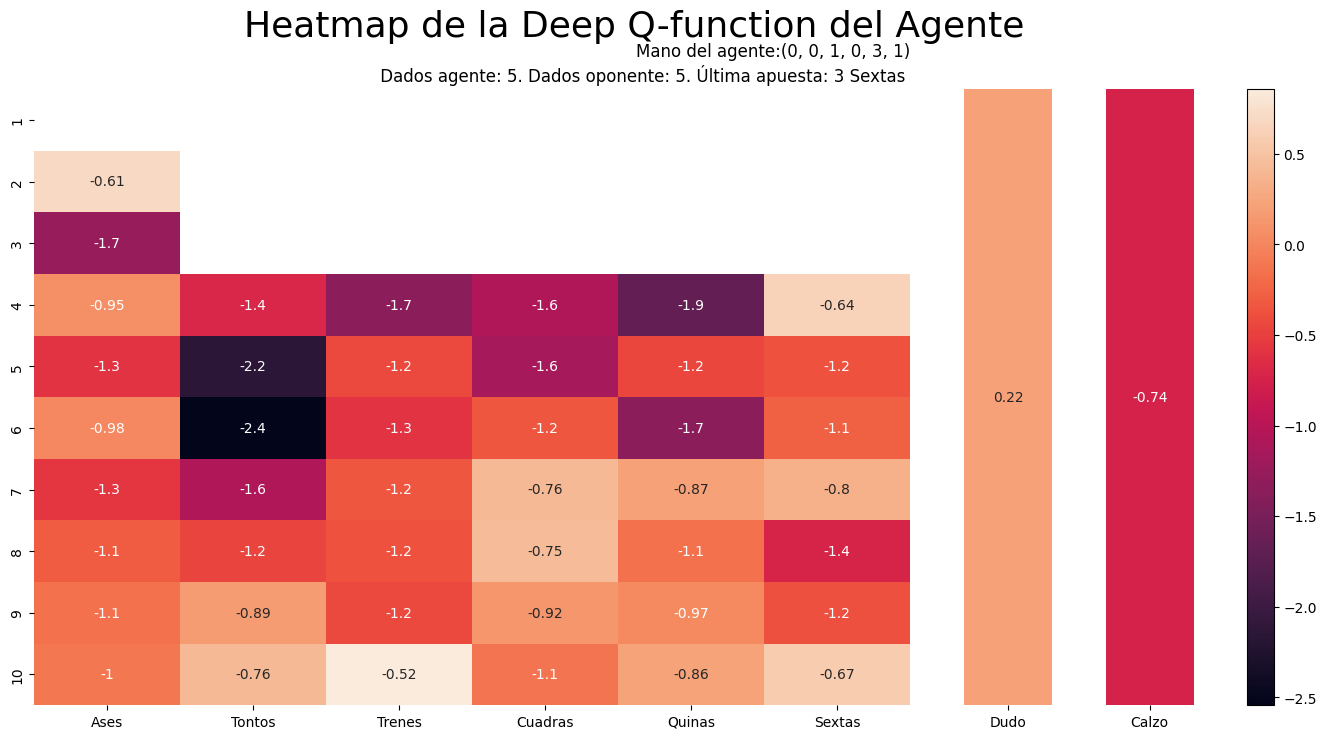

El Agente jugó Dudo
-1 ('Agent Dudo Mal', 0) (array([0, 0, 1, 0, 3, 1], dtype=int32), [4, 5], (3, 'Sextas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([1, 1, 1, 1, 0, 0], dtype=int32), array([0, 0, 3, 2, 0, 0], dtype=int32)]


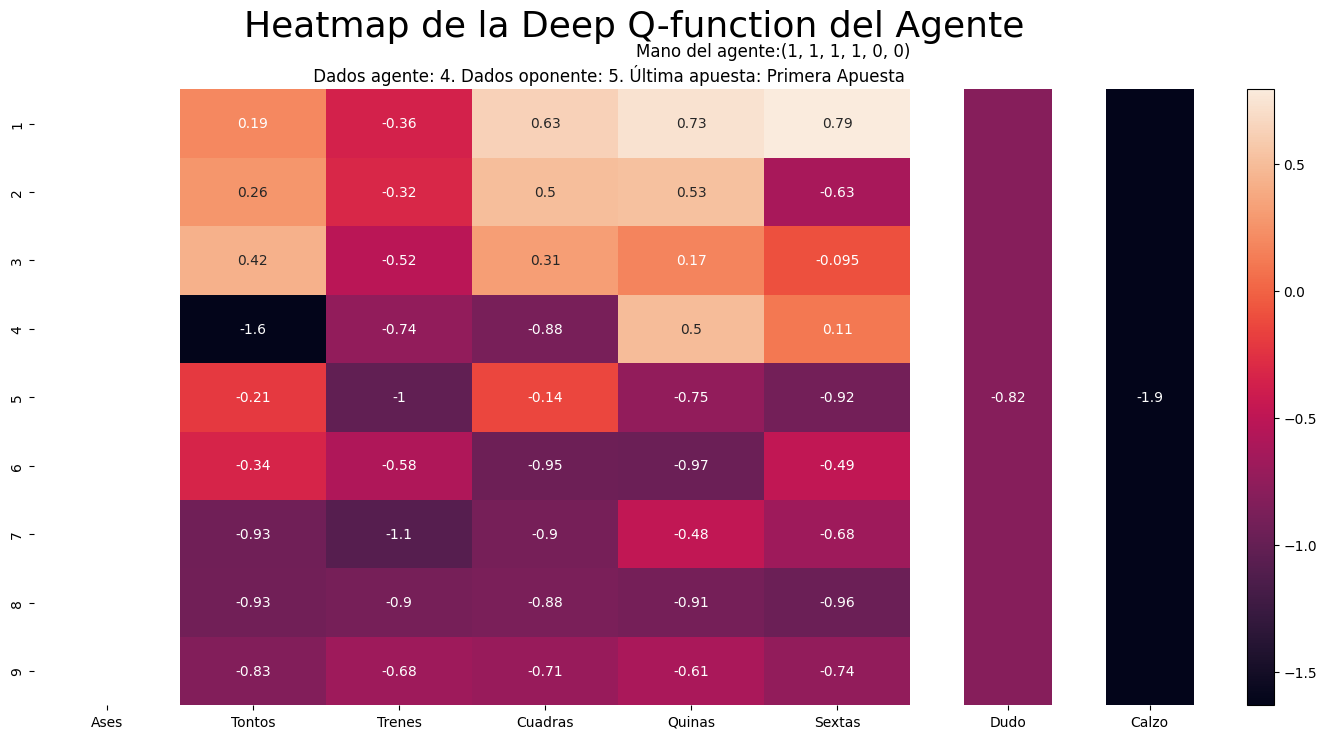

El Agente jugó (1, 'Sextas')
Oponente 1 Played:  (2, 'Sextas')


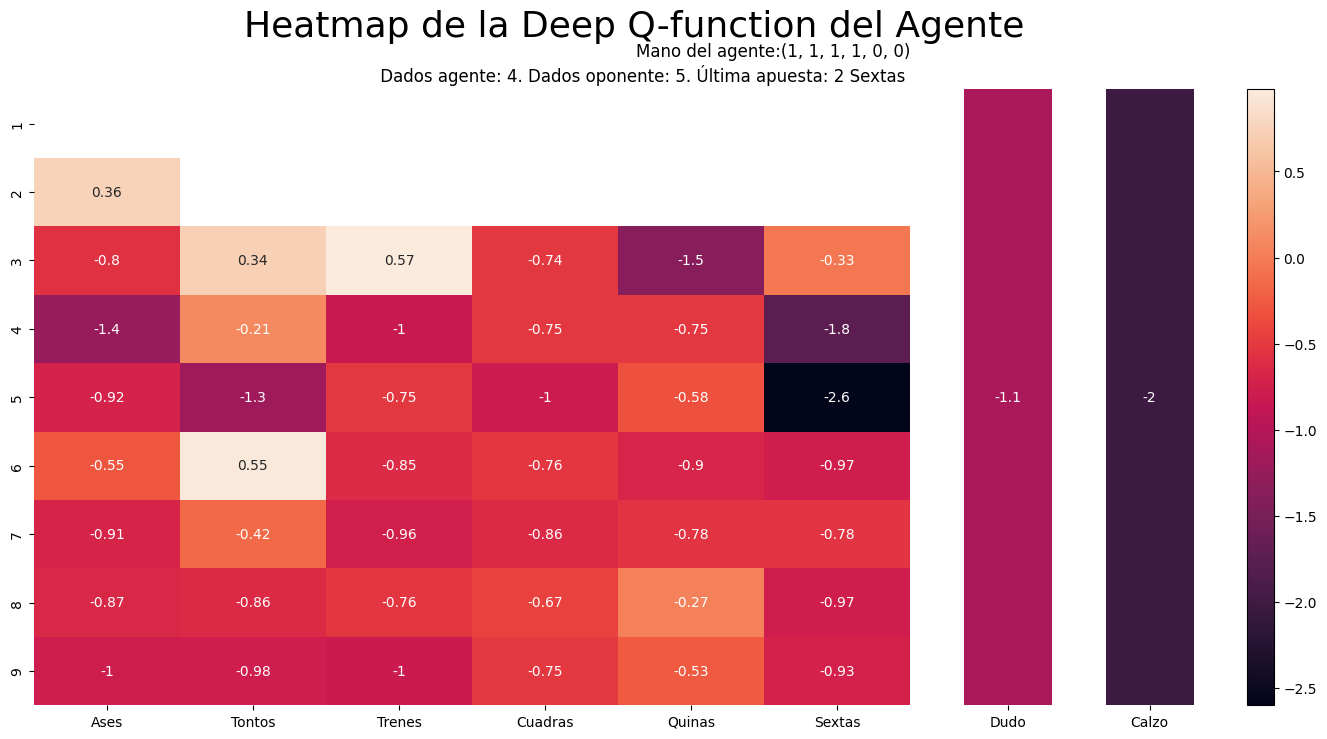

El Agente jugó (3, 'Trenes')
Oponente 1 Played:  (4, 'Trenes')


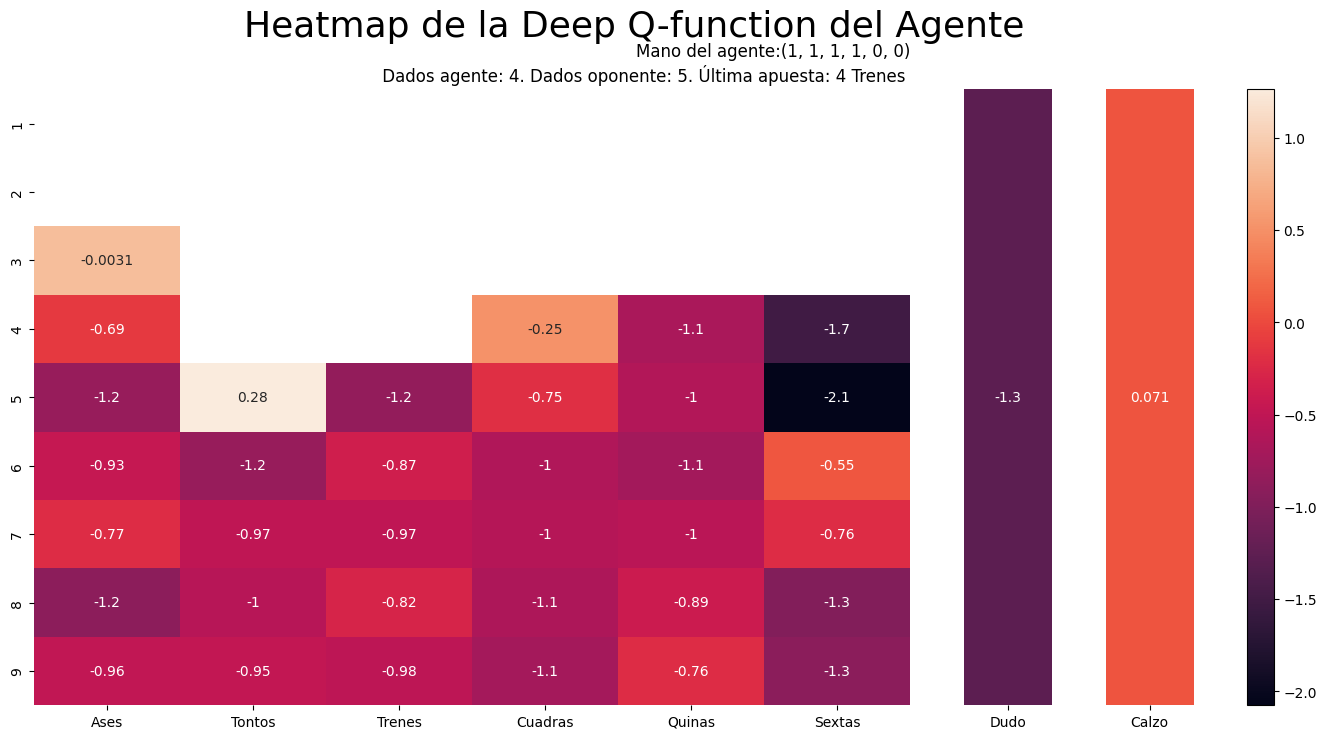

El Agente jugó (5, 'Tontos')
Oponente 1 Played:  Dudo
-1 ('Oponente 1 Dudó bien', 0) (array([1, 1, 1, 1, 0, 0], dtype=int32), [3, 5], (5, 'Tontos'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([0, 1, 0, 0, 1, 1], dtype=int32), array([2, 1, 0, 0, 1, 1], dtype=int32)]


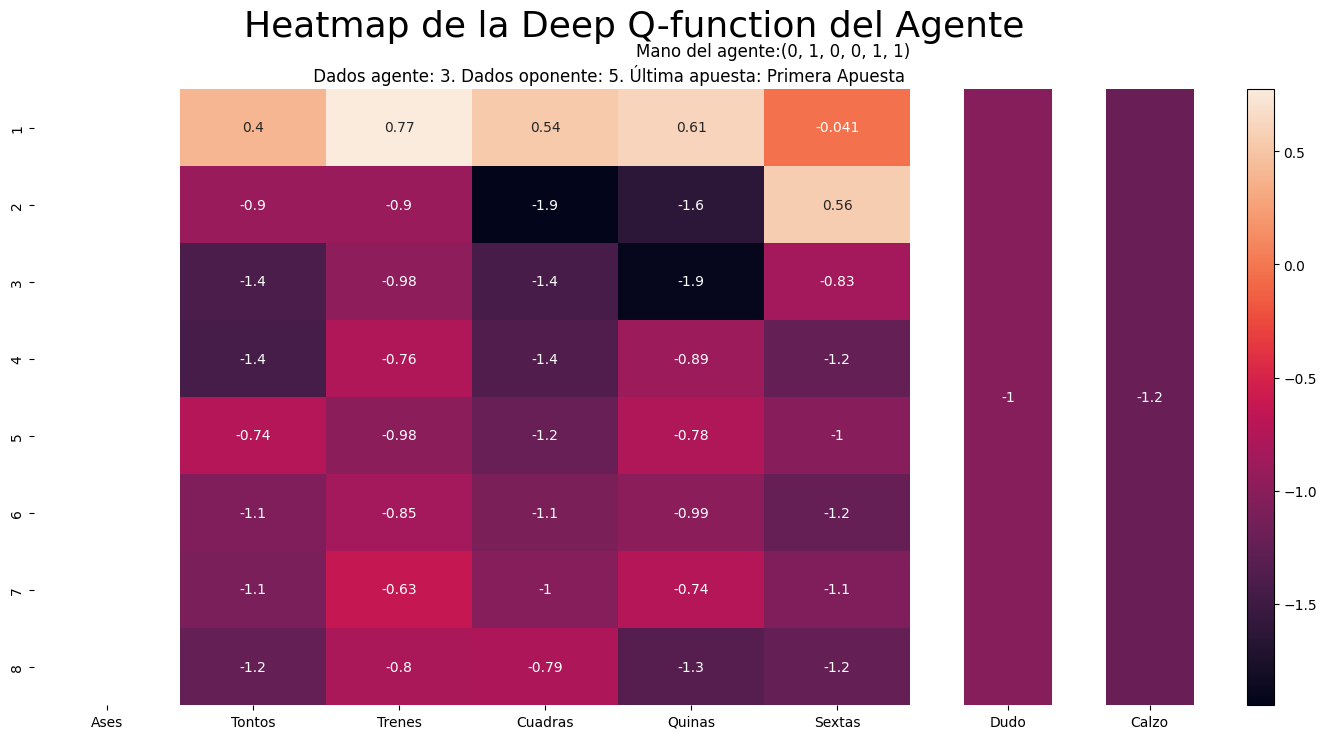

El Agente jugó (1, 'Trenes')
Oponente 1 Played:  (2, 'Trenes')


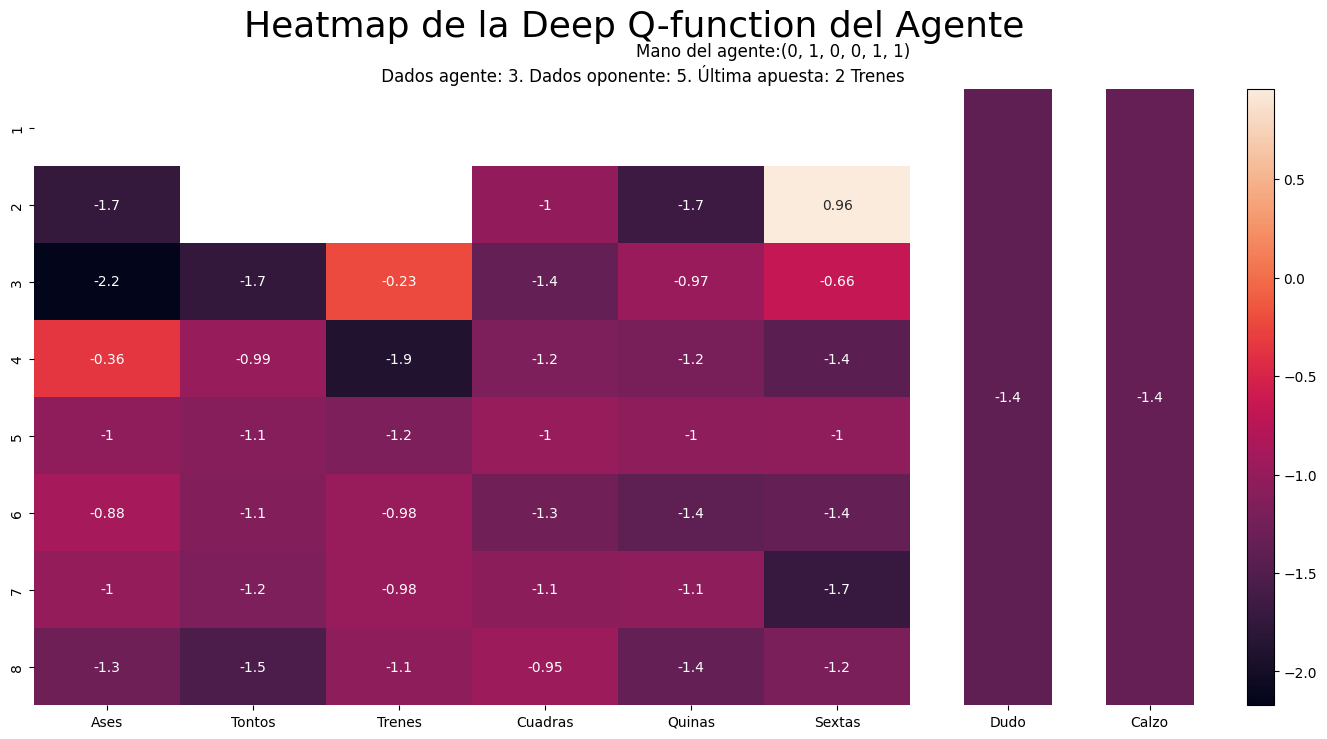

El Agente jugó (2, 'Sextas')
Oponente 1 Played:  (3, 'Sextas')


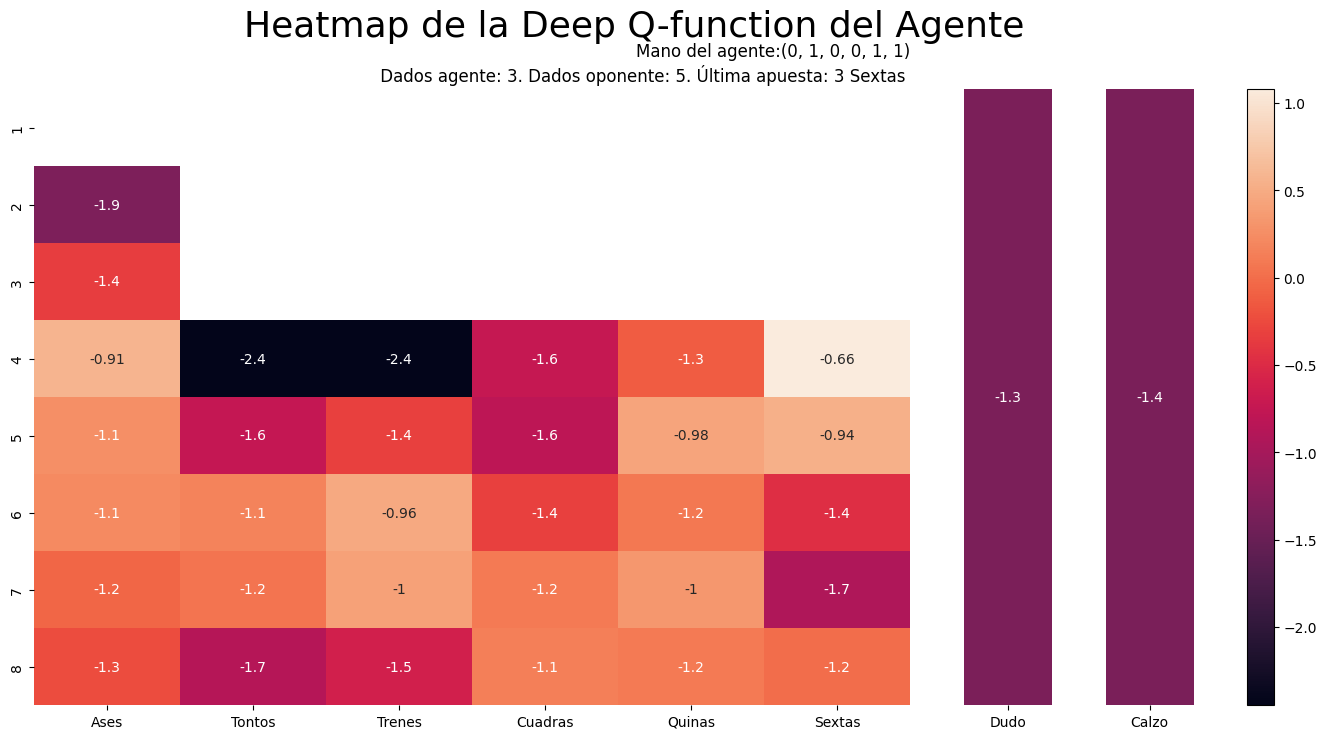

El Agente jugó (4, 'Sextas')
Oponente 1 Played:  Calzo
-1 ('Oponente 1 Calzó bien', 1) (array([0, 1, 0, 0, 1, 1], dtype=int32), [3, 5], (4, 'Sextas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([1, 1, 1, 0, 0, 0], dtype=int32), array([0, 2, 2, 0, 0, 1], dtype=int32)]
El Oponente partió jugando (1, 'Tontos')


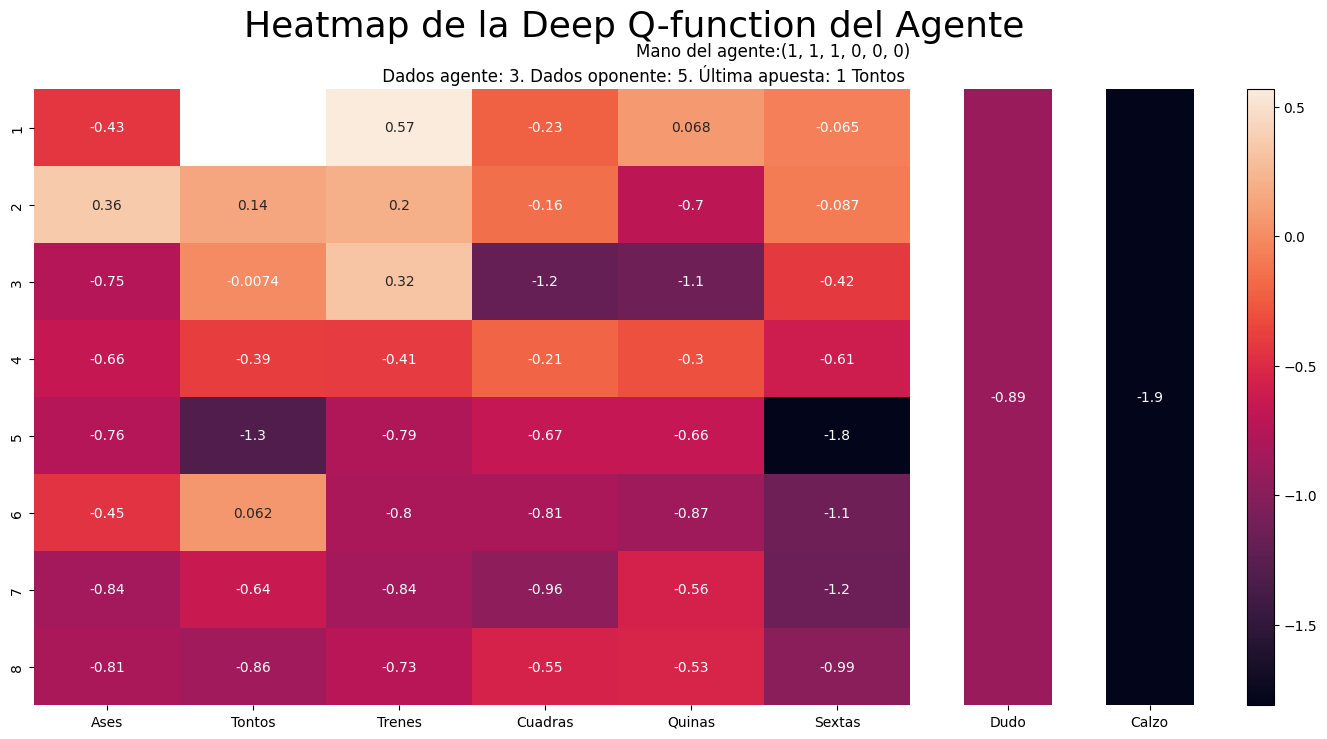

El Agente jugó (1, 'Trenes')
Oponente 1 Played:  (2, 'Trenes')


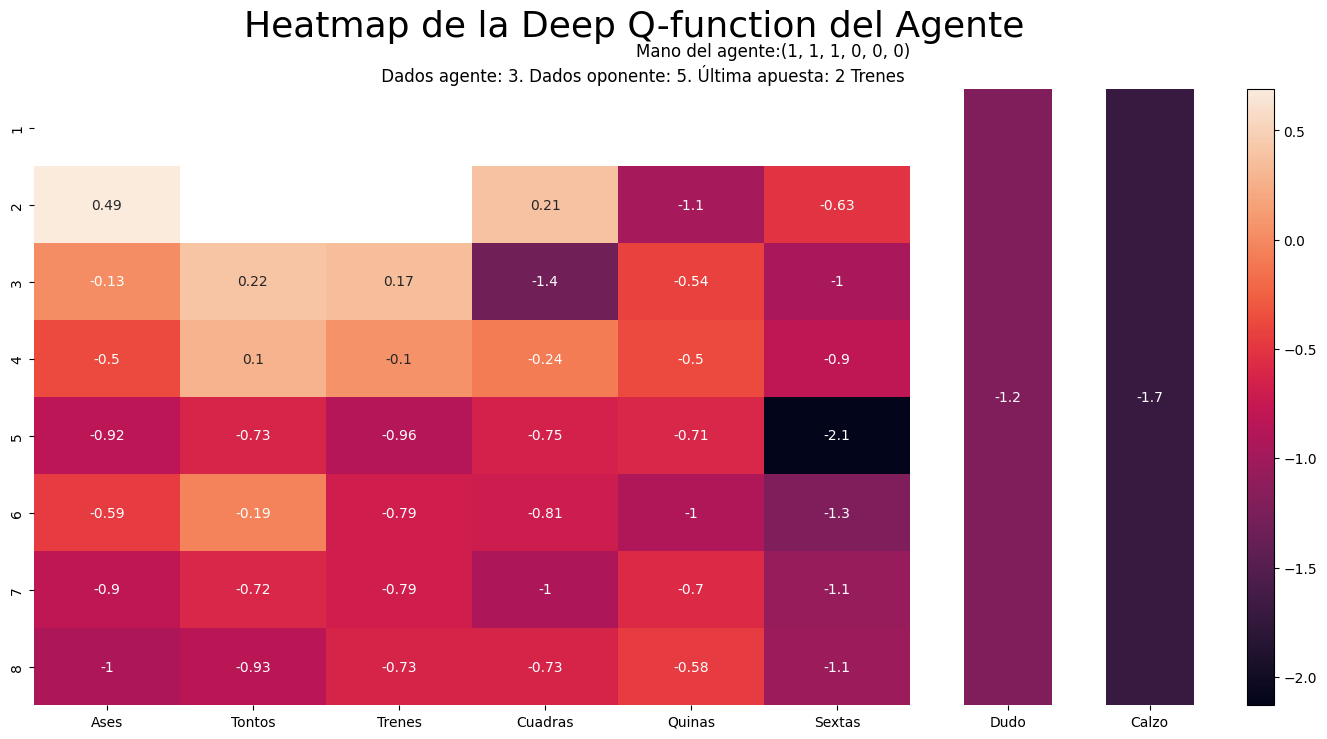

El Agente jugó (2, 'Ases')
Oponente 1 Played:  Dudo
-1 ('Oponente 1 Dudó bien', 0) (array([1, 1, 1, 0, 0, 0], dtype=int32), [2, 5], (2, 'Ases'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([0, 1, 0, 0, 0, 1], dtype=int32), array([0, 1, 0, 2, 1, 1], dtype=int32)]


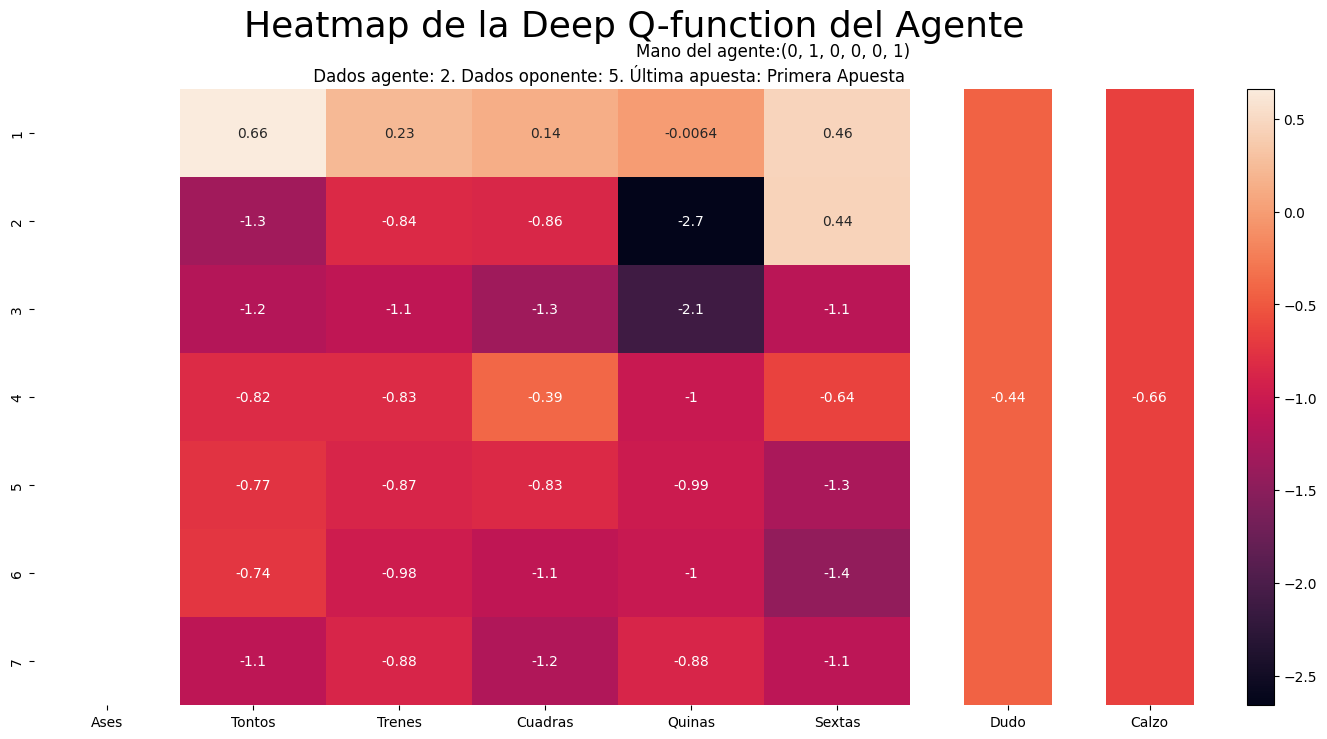

El Agente jugó (1, 'Tontos')
Oponente 1 Played:  (1, 'Cuadras')


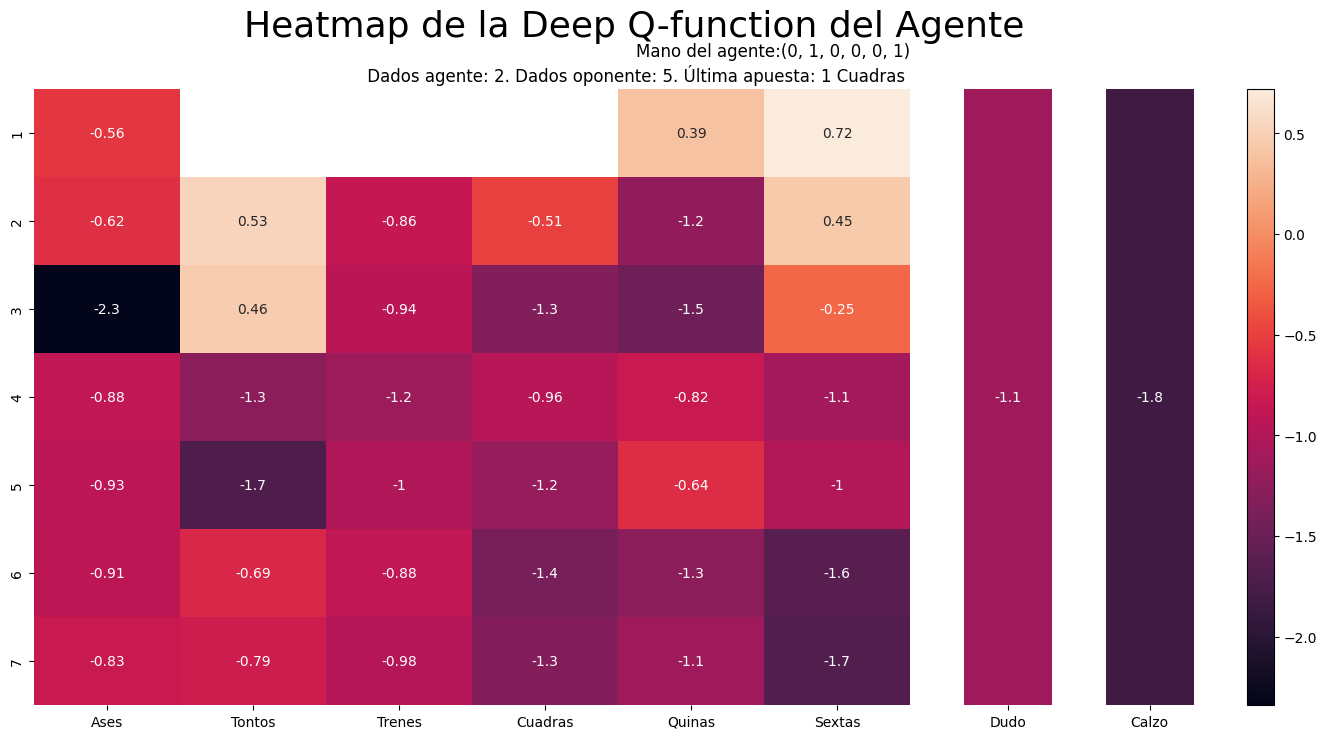

El Agente jugó (1, 'Sextas')
Oponente 1 Played:  (2, 'Sextas')


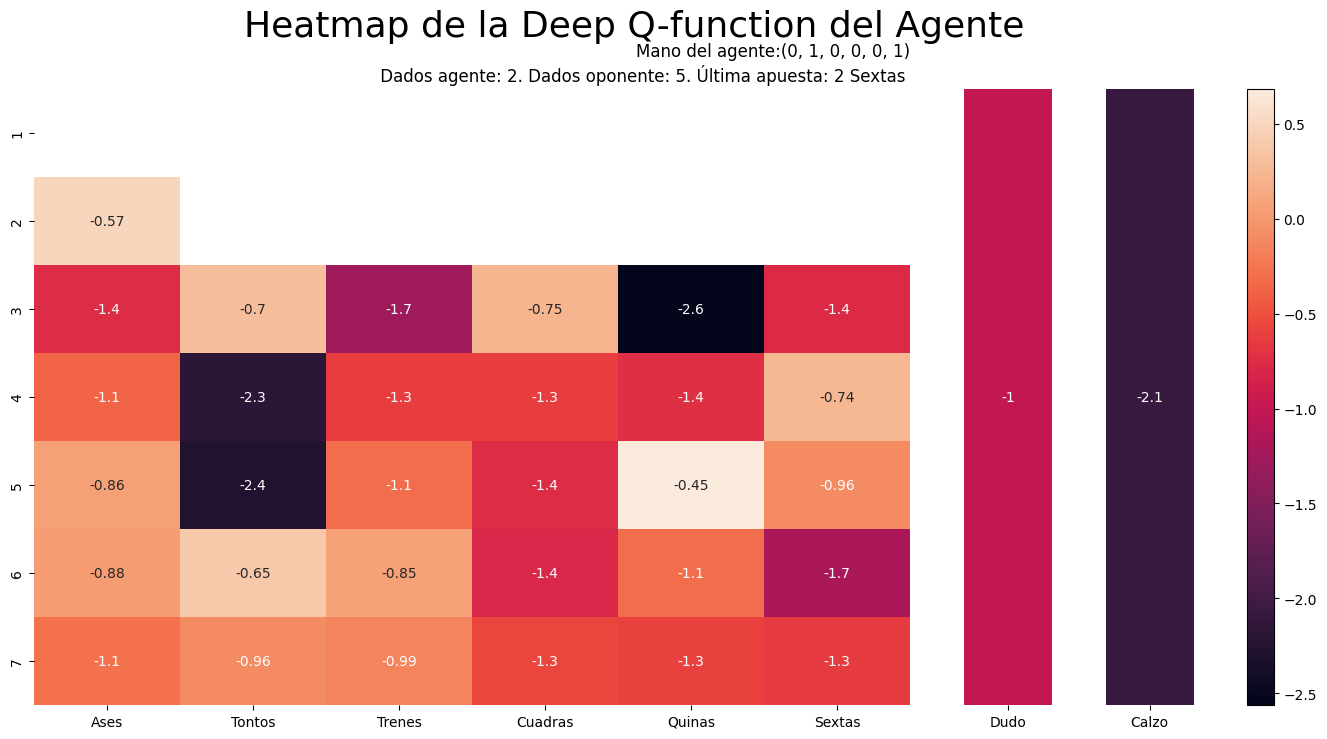

El Agente jugó (5, 'Quinas')
Oponente 1 Played:  Dudo
-1 ('Oponente 1 Dudó bien', 0) (array([0, 1, 0, 0, 0, 1], dtype=int32), [1, 5], (5, 'Quinas'))
--------------------------------------------------------------------------------
En esta ronda, los jugadores tenían los dados:
[array([0, 1, 0, 0, 0, 0], dtype=int32), array([1, 0, 1, 1, 1, 1], dtype=int32)]


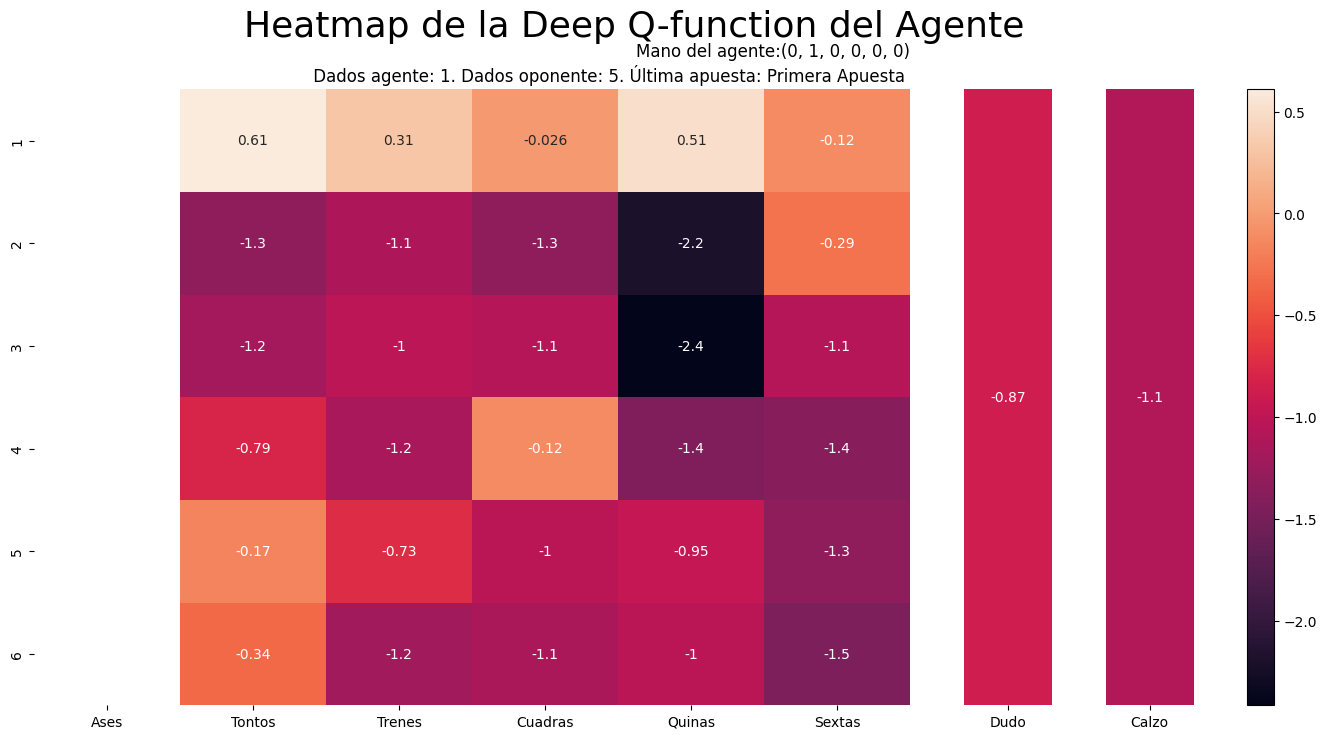

El Agente jugó (1, 'Tontos')
Oponente 1 Played:  (2, 'Tontos')


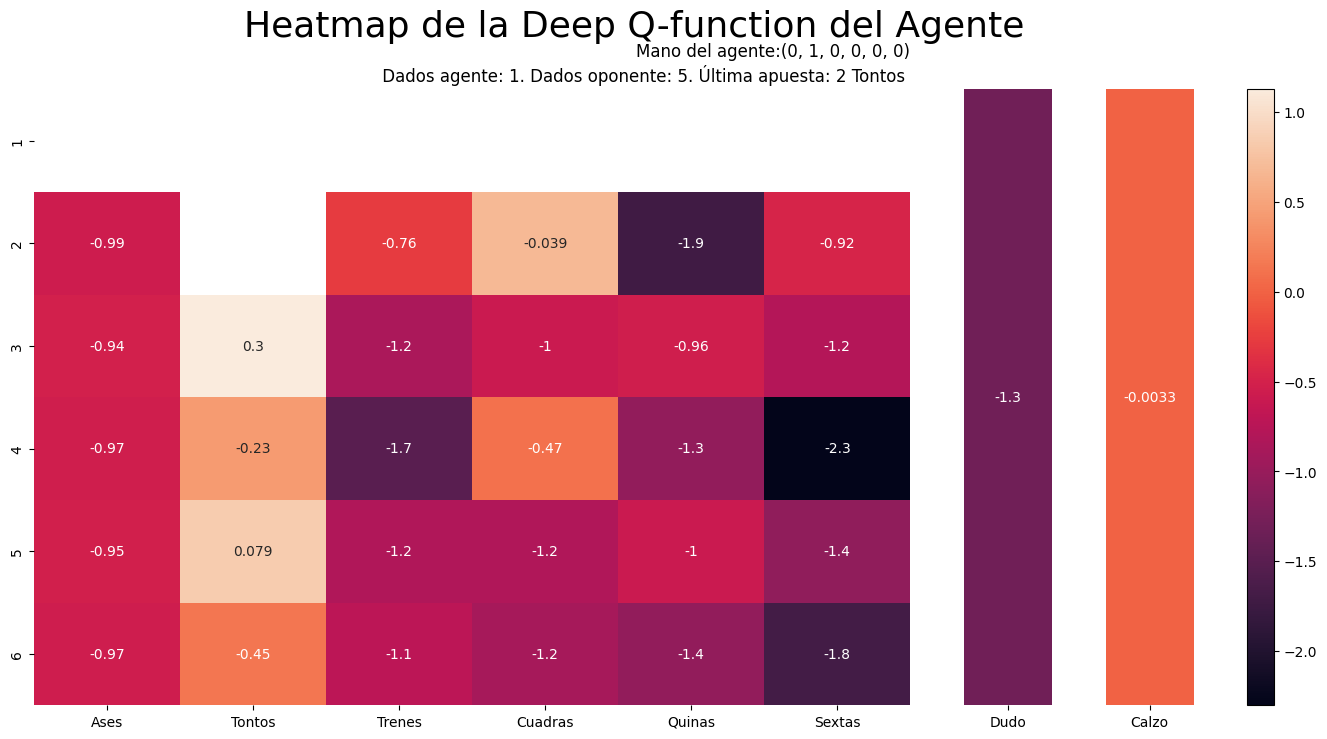

El Agente jugó (3, 'Tontos')
Oponente 1 Played:  Dudo
OPPONENT WINS !
-1 ('Oponente 1 Dudó bien', 0) (array([0, 1, 0, 0, 0, 0], dtype=int32), [0, 5], (3, 'Tontos'))
--------------------------------------------------------------------------------
Fin del Juego


(-1, 0.01, 12.662116797000001)

In [31]:
play_one_game(game_env, agente_DQN2, verbose = True, graphs = True, tabular = False)

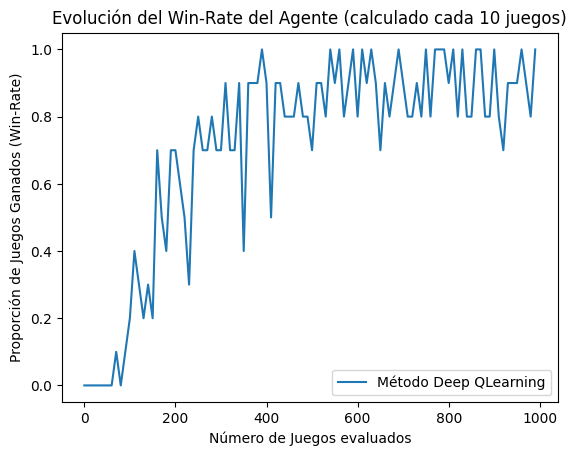

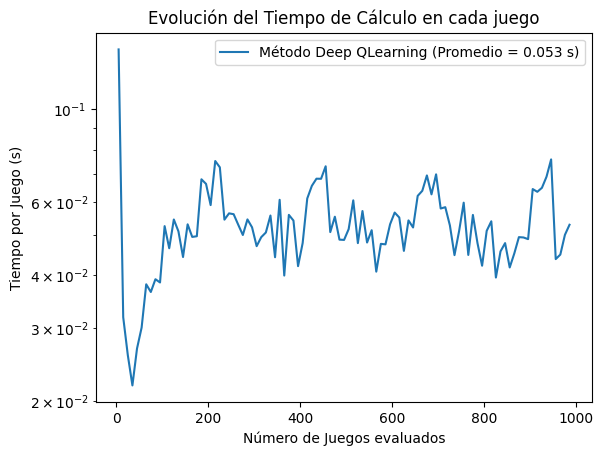

x                 499.5000
Deep QLearning      0.0528
dtype: float64


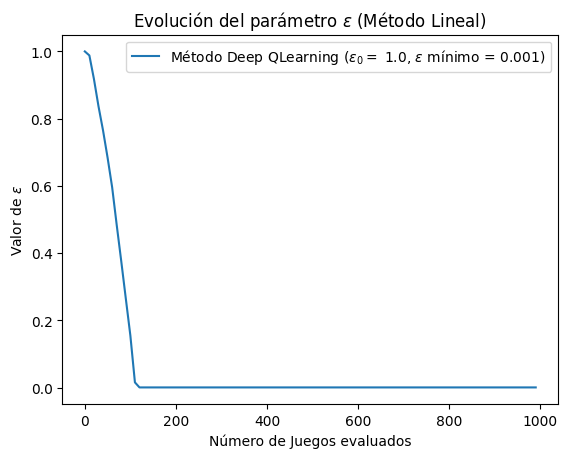

In [32]:
df_wr = pd.DataFrame(scores_dict)
df_times = pd.DataFrame(times_dict)
df_epsilons = pd.DataFrame(epsilon_dict)

plot_winrate(df_wr, every)
plot_time_per_game(df_times, m = every)
print(df_times.mean())
plot_epsilon(df_epsilons, m = every)

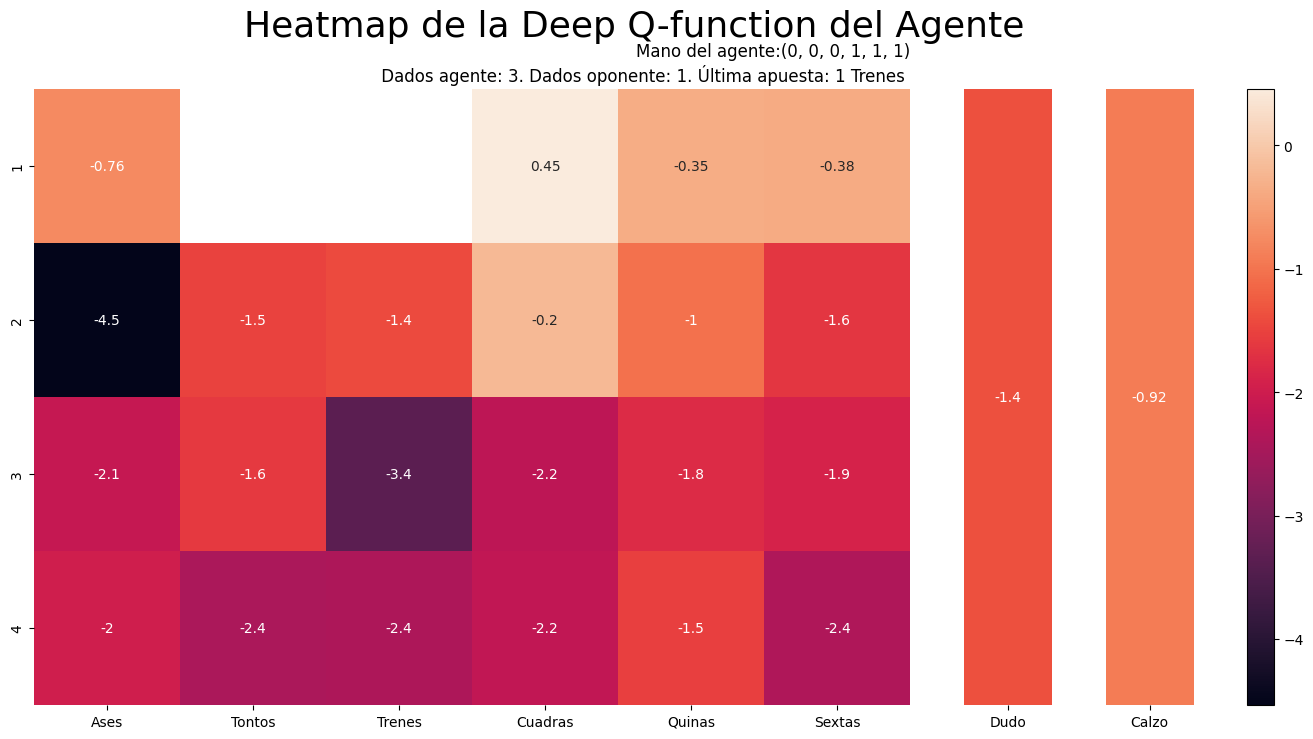

In [33]:
Q_plot(agente_DQN2, ((0,0,0,1,1,1),(3,1), (1, "Trenes")), tabular = False)

# TO DO (Trabajo a futuro):

- Pantalla interactiva clickeable usando Tkinter (https://docs.python.org/es/3/library/tkinter.html, https://stackoverflow.com/questions/24236058/how-to-use-looping-in-tkinter)
- Test jugando contra la optimal policy (entrenar vs agente entrenado)
- Implementar Expected Sarsa
- Ampliar a más de 2 jugadores
- Agregar el historial de la ronda como variable
- Testear policy gradients